In [131]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import re, struct


from typing import Dict

import warnings

In [132]:
seed_value = 36

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

In [133]:
from src.preprocessing import prepare_data, get_traintest
from src.processing import Predictor
from src.visualization import plot_result
from src.models.simple_models import OCSVM, LOF, iForest
from src.models.ae_lstm import AE_LSTM
from src.models.som import SOM

In [134]:
model_store_path = './saved_models/'

In [135]:
#pd.set_option('display.max_rows', 150)

# Загрузка данных

In [136]:
data = pd.read_csv('/opt/notebooks/cerebrum/CISS2022/ARPE/splitted_payload_192_168_1_10.csv', 
                   index_col='timestamp', 
                   parse_dates=True,
                   infer_datetime_format = True)
data

,path,id,connection_id,raw_data,len,int_data,0,1,2,3,...,71,72,73,74,75,76,77,78,79,80
timestamp,,,,,,,,,,,,,,,,,,,,,
1.575598e+09,/opt/datasets/cerebrum/SWAT/SWaT.A6_Dec 2019/D...,1107,b'\x80\x00\xfe\xb3',"b""\x00\x00\x00\x00\xff\xff\xff\xff\x00\x03B\xe...",135,"(0, 0, 0, 0, 255, 255, 255, 255, 0, 3, 66, 231...",b'\x00',b'\x00',b'\xff',b'\xff',...,b'\xc0',b'\x00>',"b""'z""",b'\xab>',b'\x05\xfa',b'\xab\x00',b'\x01\x00',b'\x00\x00',b'\xcc',b'\xcc\xad\xc0'
1.575598e+09,/opt/datasets/cerebrum/SWAT/SWaT.A6_Dec 2019/D...,1108,b'\x80\x00\xfe\xb3',"b""\x00\x00\x00\x00\xff\xff\xff\xff\x00\x03B\xe...",135,"(0, 0, 0, 0, 255, 255, 255, 255, 0, 3, 66, 231...",b'\x00',b'\x00',b'\xff',b'\xff',...,b'\xc0',b'\x00>',"b""'z""",b'\xab>',b'\x05\xfa',b'\xab\x00',b'\x01\x00',b'\x00\x00',b'\xcc',b'\xcc\xad\xc0'
1.575598e+09,/opt/datasets/cerebrum/SWAT/SWaT.A6_Dec 2019/D...,3873,b'\x80\x00\xfe\xb3',"b""\x00\x00\x00\x00\xff\xff\xff\xff\x00\x03B\xe...",135,"(0, 0, 0, 0, 255, 255, 255, 255, 0, 3, 66, 231...",b'\x00',b'\x00',b'\xff',b'\xff',...,b'\xc0',b'\x00>',"b""'z""",b'\xab>',b'\x05\xfa',b'\xab\x00',b'\x01\x00',b'\x00\x00',b'\xcc',b'\xcc\xad\xc1'
1.575598e+09,/opt/datasets/cerebrum/SWAT/SWaT.A6_Dec 2019/D...,3874,b'\x80\x00\xfe\xb3',"b""\x00\x00\x00\x00\xff\xff\xff\xff\x00\x03B\xe...",135,"(0, 0, 0, 0, 255, 255, 255, 255, 0, 3, 66, 231...",b'\x00',b'\x00',b'\xff',b'\xff',...,b'\xc0',b'\x00>',"b""'z""",b'\xab>',b'\x05\xfa',b'\xab\x00',b'\x01\x00',b'\x00\x00',b'\xcc',b'\xcc\xad\xc1'
1.575598e+09,/opt/datasets/cerebrum/SWAT/SWaT.A6_Dec 2019/D...,14933,b'\x80\x00\xfe\xb3',"b""\x00\x00\x00\x00\xff\xff\xff\xff\x00\x03B\xe...",135,"(0, 0, 0, 0, 255, 255, 255, 255, 0, 3, 66, 231...",b'\x00',b'\x00',b'\xff',b'\xff',...,b'\xc0',b'\x00>',"b""'z""",b'\xab>',b'\x05\xfa',b'\xab\x00',b'\x01\x00',b'\x00\x00',b'\xcc',b'\xcc\xad\xc2'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.575611e+09,/opt/datasets/cerebrum/SWAT/SWaT.A6_Dec 2019/D...,21902947,b'\x80\x00\xfe\xb3',"b""\x00\x00\x00\x00\xff\xff\xff\xff\x00\x03B\xe...",135,"(0, 0, 0, 0, 255, 255, 255, 255, 0, 3, 66, 235...",b'\x00',b'\x00',b'\xff',b'\xff',...,b'\xc0',b'\x00>',"b""'z""",b'\xab>',b'\x05\xfa',b'\xab\x00',b'\x01\x00',b'\x00\x00',b'\xcc',b'\xcc_g'
1.575611e+09,/opt/datasets/cerebrum/SWAT/SWaT.A6_Dec 2019/D...,21915746,b'\x80\x00\xfe\xb3',"b""\x00\x00\x00\x00\xff\xff\xff\xff\x00\x03B\xe...",135,"(0, 0, 0, 0, 255, 255, 255, 255, 0, 3, 66, 235...",b'\x00',b'\x00',b'\xff',b'\xff',...,b'\xc0',b'\x00>',"b""'z""",b'\xab>',b'\x05\xfa',b'\xab\x00',b'\x01\x00',b'\x00\x00',b'\xcc',b'\xcc_h'
1.575611e+09,/opt/datasets/cerebrum/SWAT/SWaT.A6_Dec 2019/D...,21915747,b'\x80\x00\xfe\xb3',"b""\x00\x00\x00\x00\xff\xff\xff\xff\x00\x03B\xe...",135,"(0, 0, 0, 0, 255, 255, 255, 255, 0, 3, 66, 235...",b'\x00',b'\x00',b'\xff',b'\xff',...,b'\xc0',b'\x00>',"b""'z""",b'\xab>',b'\x05\xfa',b'\xab\x00',b'\x01\x00',b'\x00\x00',b'\xcc',b'\xcc_h'


In [137]:
data.index = pd.to_datetime(data.index, unit='s')

In [138]:
data['path'] = data['path'].apply(lambda x: x[74:77])

In [139]:
data

,path,id,connection_id,raw_data,len,int_data,0,1,2,3,...,71,72,73,74,75,76,77,78,79,80
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-12-06 02:05:04.415631056,015,1107,b'\x80\x00\xfe\xb3',"b""\x00\x00\x00\x00\xff\xff\xff\xff\x00\x03B\xe...",135,"(0, 0, 0, 0, 255, 255, 255, 255, 0, 3, 66, 231...",b'\x00',b'\x00',b'\xff',b'\xff',...,b'\xc0',b'\x00>',"b""'z""",b'\xab>',b'\x05\xfa',b'\xab\x00',b'\x01\x00',b'\x00\x00',b'\xcc',b'\xcc\xad\xc0'
2019-12-06 02:05:04.415632010,015,1108,b'\x80\x00\xfe\xb3',"b""\x00\x00\x00\x00\xff\xff\xff\xff\x00\x03B\xe...",135,"(0, 0, 0, 0, 255, 255, 255, 255, 0, 3, 66, 231...",b'\x00',b'\x00',b'\xff',b'\xff',...,b'\xc0',b'\x00>',"b""'z""",b'\xab>',b'\x05\xfa',b'\xab\x00',b'\x01\x00',b'\x00\x00',b'\xcc',b'\xcc\xad\xc0'
2019-12-06 02:05:04.532814026,015,3873,b'\x80\x00\xfe\xb3',"b""\x00\x00\x00\x00\xff\xff\xff\xff\x00\x03B\xe...",135,"(0, 0, 0, 0, 255, 255, 255, 255, 0, 3, 66, 231...",b'\x00',b'\x00',b'\xff',b'\xff',...,b'\xc0',b'\x00>',"b""'z""",b'\xab>',b'\x05\xfa',b'\xab\x00',b'\x01\x00',b'\x00\x00',b'\xcc',b'\xcc\xad\xc1'
2019-12-06 02:05:04.532814980,015,3874,b'\x80\x00\xfe\xb3',"b""\x00\x00\x00\x00\xff\xff\xff\xff\x00\x03B\xe...",135,"(0, 0, 0, 0, 255, 255, 255, 255, 0, 3, 66, 231...",b'\x00',b'\x00',b'\xff',b'\xff',...,b'\xc0',b'\x00>',"b""'z""",b'\xab>',b'\x05\xfa',b'\xab\x00',b'\x01\x00',b'\x00\x00',b'\xcc',b'\xcc\xad\xc1'
2019-12-06 02:05:04.913991928,015,14933,b'\x80\x00\xfe\xb3',"b""\x00\x00\x00\x00\xff\xff\xff\xff\x00\x03B\xe...",135,"(0, 0, 0, 0, 255, 255, 255, 255, 0, 3, 66, 231...",b'\x00',b'\x00',b'\xff',b'\xff',...,b'\xc0',b'\x00>',"b""'z""",b'\xab>',b'\x05\xfa',b'\xab\x00',b'\x01\x00',b'\x00\x00',b'\xcc',b'\xcc\xad\xc2'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-06 05:45:02.793700933,011,21902947,b'\x80\x00\xfe\xb3',"b""\x00\x00\x00\x00\xff\xff\xff\xff\x00\x03B\xe...",135,"(0, 0, 0, 0, 255, 255, 255, 255, 0, 3, 66, 235...",b'\x00',b'\x00',b'\xff',b'\xff',...,b'\xc0',b'\x00>',"b""'z""",b'\xab>',b'\x05\xfa',b'\xab\x00',b'\x01\x00',b'\x00\x00',b'\xcc',b'\xcc_g'
2019-12-06 05:45:03.292222023,011,21915746,b'\x80\x00\xfe\xb3',"b""\x00\x00\x00\x00\xff\xff\xff\xff\x00\x03B\xe...",135,"(0, 0, 0, 0, 255, 255, 255, 255, 0, 3, 66, 235...",b'\x00',b'\x00',b'\xff',b'\xff',...,b'\xc0',b'\x00>',"b""'z""",b'\xab>',b'\x05\xfa',b'\xab\x00',b'\x01\x00',b'\x00\x00',b'\xcc',b'\xcc_h'
2019-12-06 05:45:03.292222977,011,21915747,b'\x80\x00\xfe\xb3',"b""\x00\x00\x00\x00\xff\xff\xff\xff\x00\x03B\xe...",135,"(0, 0, 0, 0, 255, 255, 255, 255, 0, 3, 66, 235...",b'\x00',b'\x00',b'\xff',b'\xff',...,b'\xc0',b'\x00>',"b""'z""",b'\xab>',b'\x05\xfa',b'\xab\x00',b'\x01\x00',b'\x00\x00',b'\xcc',b'\xcc_h'


### Работаем с byte

In [329]:
df_bytes = data.copy().drop(['path', 'connection_id', 'raw_data', 'len', 'int_data'], axis=1)

In [330]:
df_bytes

,id,0,1,2,3,4,5,6,7,8,...,71,72,73,74,75,76,77,78,79,80
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-12-06 02:05:04.415631056,1107,b'\x00',b'\x00',b'\xff',b'\xff',b'\xff',b'\xff',b'\x00\x03',b'B\xe7',b';\xbc',...,b'\xc0',b'\x00>',"b""'z""",b'\xab>',b'\x05\xfa',b'\xab\x00',b'\x01\x00',b'\x00\x00',b'\xcc',b'\xcc\xad\xc0'
2019-12-06 02:05:04.415632010,1108,b'\x00',b'\x00',b'\xff',b'\xff',b'\xff',b'\xff',b'\x00\x03',b'B\xe7',b';\xbc',...,b'\xc0',b'\x00>',"b""'z""",b'\xab>',b'\x05\xfa',b'\xab\x00',b'\x01\x00',b'\x00\x00',b'\xcc',b'\xcc\xad\xc0'
2019-12-06 02:05:04.532814026,3873,b'\x00',b'\x00',b'\xff',b'\xff',b'\xff',b'\xff',b'\x00\x03',b'B\xe7',b';\xbc',...,b'\xc0',b'\x00>',"b""'z""",b'\xab>',b'\x05\xfa',b'\xab\x00',b'\x01\x00',b'\x00\x00',b'\xcc',b'\xcc\xad\xc1'
2019-12-06 02:05:04.532814980,3874,b'\x00',b'\x00',b'\xff',b'\xff',b'\xff',b'\xff',b'\x00\x03',b'B\xe7',b';\xbc',...,b'\xc0',b'\x00>',"b""'z""",b'\xab>',b'\x05\xfa',b'\xab\x00',b'\x01\x00',b'\x00\x00',b'\xcc',b'\xcc\xad\xc1'
2019-12-06 02:05:04.913991928,14933,b'\x00',b'\x00',b'\xff',b'\xff',b'\xff',b'\xff',b'\x00\x03',b'B\xe7',b';\xbc',...,b'\xc0',b'\x00>',"b""'z""",b'\xab>',b'\x05\xfa',b'\xab\x00',b'\x01\x00',b'\x00\x00',b'\xcc',b'\xcc\xad\xc2'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-06 05:45:02.793700933,21902947,b'\x00',b'\x00',b'\xff',b'\xff',b'\xff',b'\xff',b'\x00\x03',b'B\xeb',b'\xdd\xde',...,b'\xc0',b'\x00>',"b""'z""",b'\xab>',b'\x05\xfa',b'\xab\x00',b'\x01\x00',b'\x00\x00',b'\xcc',b'\xcc_g'
2019-12-06 05:45:03.292222023,21915746,b'\x00',b'\x00',b'\xff',b'\xff',b'\xff',b'\xff',b'\x00\x03',b'B\xeb',b'\xdd\xde',...,b'\xc0',b'\x00>',"b""'z""",b'\xab>',b'\x05\xfa',b'\xab\x00',b'\x01\x00',b'\x00\x00',b'\xcc',b'\xcc_h'
2019-12-06 05:45:03.292222977,21915747,b'\x00',b'\x00',b'\xff',b'\xff',b'\xff',b'\xff',b'\x00\x03',b'B\xeb',b'\xdd\xde',...,b'\xc0',b'\x00>',"b""'z""",b'\xab>',b'\x05\xfa',b'\xab\x00',b'\x01\x00',b'\x00\x00',b'\xcc',b'\xcc_h'


In [331]:
df_bytes = df_bytes[~df_bytes.index.duplicated(keep='first')].sort_index()

In [332]:
def extract_bytes(value):
    splitted_string = re.split(r'\\x', value[:-1])
    if len(splitted_string) > 1:
        splitted_bytes = splitted_string[1:]
        return splitted_bytes
    else:
        return None
    
def count_bytes_len(value):
    splitted_string = re.split(r'\\x', value[:-1])
    
    return len(splitted_string)

def convert_bytes(string_hex):
    
    try:
        bytes_list = re.findall(r'\\x\w{2}', string_hex)
        if len(bytes_list) == 1:
            return struct.unpack('B', bytes_list[0].encode().decode('unicode_escape').encode("raw_unicode_escape"))[0]
        
        elif len(bytes_list) == 2:
            return struct.unpack('H', ''.join(bytes_list).encode().decode('unicode_escape').encode("raw_unicode_escape"))[0]
        
        elif len(bytes_list) == 3:
            if bytes_list == ['\\x00', '\\x00', '\\x00']: 
                return -1
            else:
                #rint('[3]', bytes_list)
                return -1
        
        elif len(bytes_list) == 4:
            return struct.unpack('<f',''.join(bytes_list).encode().decode('unicode_escape').encode("raw_unicode_escape"))[0]
            
        
    except Exception as err:
        print(err, string_hex)
        return None
        
        

In [333]:
df_bytes_ = df_bytes.drop('id', axis=1)
df_bytes_len = df_bytes_.applymap(count_bytes_len)
not_byte_columns = []
constant_columns = []

for col in df_bytes_len.columns:
    col_unique_values = df_bytes_len[col].unique()
    if col_unique_values.shape[0]==1 and col_unique_values[0]==1:
        not_byte_columns.append(col)
        
print('not bytes:', bad_columns, 'lenght:', len(not_byte_columns))

for col in df_bytes_len.drop(not_byte_columns, axis=1).columns:
    col_unique_values = df_bytes_[col].unique()
    if col_unique_values.shape[0]==1:
        constant_columns.append(col)

print('constant:', constant_columns, 'lenght:', len(constant_columns))

df_bytes_ = df_bytes_.drop(constant_columns+not_byte_columns, axis=1)  

not bytes: ['11', '13', '15', '16', '24', '25', '26', '27', '31', '42', '49', '54', '55', '63', '64', '69', '73'] lenght: 17
constant: ['0', '1', '2', '3', '4', '6', '9', '10', '12', '14', '17', '18', '20', '23', '28', '29', '34', '36', '43', '44', '45', '46', '47', '48', '50', '57', '58', '59', '60', '61', '62', '65', '70', '71', '72', '74', '75', '76', '77', '78', '79'] lenght: 41


In [334]:
df_bytes_

,5,7,8,19,21,22,30,32,33,35,...,40,41,51,52,53,56,66,67,68,80
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-12-06 02:05:04.415631056,b'\xff',b'B\xe7',b';\xbc',b'\x01\x00',b'\x01\x01',b'\x00\x03',b'\x00\x02',b'i\x99',b'\x9a\x01',b'\x02',...,b'\x00\x01',b'\x13C',b'\x00D',b'$\xf0',b'\xaa ',b'<\xfd',b'\x00\x00',b'\x00\x00\x00',b'\x0c',b'\xcc\xad\xc0'
2019-12-06 02:05:04.415632010,b'\xff',b'B\xe7',b';\xbc',b'\x01\x00',b'\x01\x01',b'\x00\x03',b'\x00\x02',b'i\x99',b'\x9a\x01',b'\x02',...,b'\x00\x01',b'\x13C',b'\x00D',b'$\xf0',b'\xaa ',b'<\xfd',b'\x00\x00',b'\x00\x00\x00',b'\x0c',b'\xcc\xad\xc0'
2019-12-06 02:05:04.532814026,b'\xff',b'B\xe7',b';\xbc',b'\x01\x00',b'\x01\x01',b'\x00\x03',b'\x00\x02',b'i\x99',b'\x9a\x01',b'\x02',...,b'\x00\x01',b'\x13C',b'\x00D',b'$\xeb',b'\xa3 ',b'<\xfd',b'\x00\x00',b'\x00\x00\x00',b'\x0c',b'\xcc\xad\xc1'
2019-12-06 02:05:04.532814980,b'\xff',b'B\xe7',b';\xbc',b'\x01\x00',b'\x01\x01',b'\x00\x03',b'\x00\x02',b'i\x99',b'\x9a\x01',b'\x02',...,b'\x00\x01',b'\x13C',b'\x00D',b'$\xeb',b'\xa3 ',b'<\xfd',b'\x00\x00',b'\x00\x00\x00',b'\x0c',b'\xcc\xad\xc1'
2019-12-06 02:05:04.913991928,b'\xff',b'B\xe7',b';\xbc',b'\x01\x00',b'\x01\x01',b'\x00\x03',b'\x00\x02',b'i\x99',b'\x9a\x01',b'\x02',...,b'\x00\x01',b'\x13C',b'\x00D',b'$\xf8',b'3 ',b'<\xfd',b'\x00\x00',b'\x00\x00\x00',b'\x0c',b'\xcc\xad\xc2'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-06 05:45:02.793700933,b'\xff',b'B\xeb',b'\xdd\xde',b'\x01\x00',b'\x01\x01',b'\x00\x02',b'\x00\x02',b'\x87U',b'U\x01',b'\x02',...,b'\x00\x01',b'\x13C',b'\x00D',b'/@',b'\xf6 ',b'gD',b'\x00\x00',b'\x00\x00\x00',b'\x0c',b'\xcc_g'
2019-12-06 05:45:03.292222023,b'\xff',b'B\xeb',b'\xdd\xde',b'\x01\x00',b'\x01\x01',b'\x00\x02',b'\x00\x02',b'\x87U',b'U\x01',b'\x02',...,b'\x00\x01',b'\x13C',b'\x00D',b'/;',b'\xf0 ',b'gD',b'\x00\x00',b'\x00\x00\x00',b'\x0c',b'\xcc_h'
2019-12-06 05:45:03.292222977,b'\xff',b'B\xeb',b'\xdd\xde',b'\x01\x00',b'\x01\x01',b'\x00\x02',b'\x00\x02',b'\x87U',b'U\x01',b'\x02',...,b'\x00\x01',b'\x13C',b'\x00D',b'/;',b'\xf0 ',b'gD',b'\x00\x00',b'\x00\x00\x00',b'\x0c',b'\xcc_h'


In [335]:
for col in df_bytes_.columns:
    display(df_bytes_[col].value_counts())

b'\xff'    53917
b'\xfd'    30485
Name: 5, dtype: int64

b'B\xe9'    22551
b'B\xe8'    19753
b'B\xeb'    17074
b'B\xea'    15681
b'B\xe7'     9343
Name: 7, dtype: int64

b'\x99\x9a'    9660
b'\xf7w'       8478
b'L\xcd'       8381
b'\x91\x11'    5616
b'\xee\xef'    5190
b'\xdd\xde'    3618
b'\xaa\xab'    2047
b'\xb33'       2041
b'\x80\x00'    2031
b'ff'          2028
b'\x88\x89'    2023
b'ww'          2019
b'DD'          2015
b'\xbb\xbc'    2006
b'UU'          2001
b'\xa2"'       1993
b'n\xef'       1971
b']\xde'       1954
b'\xc4D'       1628
b'\xe6f'       1627
b'\x08\x89'    1627
b'\x19\x9a'    1626
b'*\xab'       1621
b'\xd5U'       1616
b'\x00\x00'    1614
b'""'          1608
b'\xcc\xcd'    1605
b'33'          1595
b'\x11\x11'    1593
b';\xbc'       1570
Name: 8, dtype: int64

b'\x01\x00'    78392
b'\x00\x00'     6010
Name: 19, dtype: int64

b'\x01\x01'    53871
b'\x01\x00'    30531
Name: 21, dtype: int64

b'\x00\x03'    45807
b'\x00\x02'    38595
Name: 22, dtype: int64

b'\x00\x02'    53871
b'\x00\x01'    30531
Name: 30, dtype: int64

b't\x88'       8063
b'\x7fw'       7257
b'\x85\x11'    6788
b'|D'          4023
b'\x83\x99'    4017
               ... 
b'\x813'        375
b'q\x99'        375
b'\x87U'        351
b'\x85U'        350
b'i\x99'         13
Name: 32, Length: 137, dtype: int64

b'\x89\x01'    11332
b'w\x01'       10504
b'\x11\x01'    10030
b'D\x01'        7196
b'\x9a\x01'     6761
b'\xab\x01'     5671
b'\xef\x01'     4057
b'3\x01'        3960
b'\x00\x01'     3650
b'\xbc\x01'     3646
b'f\x01'        3622
b'\xcd\x01'     3612
b'"\x01'        3591
b'U\x01'        3537
b'\xde\x01'     3233
Name: 33, dtype: int64

b'\x02'    53871
b'\x01'    30531
Name: 35, dtype: int64

b'\x02\x00'    53916
b'\x01\x00'    29918
b'\x00\x00'      568
Name: 37, dtype: int64

b'\x02\x13'    54185
b'\x01\x13'    30217
Name: 38, dtype: int64

b'\x00\x01'    80386
b'\x00\x02'     3788
b'\x00\x00'      228
Name: 39, dtype: int64

b'\x00\x01'    80500
b'\x00\x02'     3902
Name: 40, dtype: int64

b'\x13C'    78394
b'\x01C'     6008
Name: 41, dtype: int64

b'\x00D'    83211
b'\x00C'     1191
Name: 51, dtype: int64

b'K\xbd'       358
b'K\xb3'       353
b'K\xb1'       333
b'K\xb8'       325
b'K\xbb'       307
              ... 
b'\x04/'         1
b'\xffz'         1
b'\xf9K'         1
b'\x12\xe4'      1
b'\x05\xaf'      1
Name: 52, Length: 5804, dtype: int64

b'W '       512
b'\xce '    492
b'\x19 '    482
b'\xa8 '    473
b'8 '       459
           ... 
b'\xc5$'      2
b'\x81$'      2
b'\x0b$'      2
b'\n$'        2
b'\xc0$'      2
Name: 53, Length: 542, dtype: int64

b'\xbb\xc1'    29357
b'\x1c\xeb'    24871
b'gD'          20317
b'<\xfd'        6081
b'\xf9\xf7'       10
               ...  
b'\xff;'           4
b'\xfd\xfc'        4
b'\xfe\x9b'        4
b'\xfd^'           4
b'&L'              3
Name: 56, Length: 557, dtype: int64

b'\x00\x00'    74267
b'@ '           6008
b'@\x8b'        2049
b'@\x8c'        1694
b'@\x8a'          18
               ...  
b'@z'              2
b'@n'              1
b'@+'              1
b'>-'              1
b'>\x8c'           1
Name: 66, Length: 140, dtype: int64

b'\x00\x00\x00'    80275
b'S\xcb\x04'         112
b'\xc3}\x04'         110
b'\xf7\xf7\x04'      104
b'\x96\xe3\x04'      103
                   ...  
b'Ts\x04'              2
b'\xdc:\x04'           1
b'\x96\x19\x04'        1
b'\x15\xe6\x04'        1
b's*\x04'              1
Name: 67, Length: 275, dtype: int64

b'\x0c'    74365
b'\x10'     6008
b'\x03'     3841
b'\x00'       94
b'\x02'       65
b'\x04'       29
Name: 68, dtype: int64

b'\xcc\xd4\xb6'    4
b'\xccXt'          4
b'\xcc\xd5\xda'    3
b'\xcc\xe8\xcf'    2
b'\xcc\x14v'       2
                  ..
b'\xccN\xf0'       1
b'\xccB\xf0'       1
b'\xcc\xce('       1
b'\xcc@\x02'       1
b'\xcc\xc4\xbc'    1
Name: 80, Length: 43397, dtype: int64

In [336]:
df_bytes_.iloc[10,10]

"b'\\x02\\x00'"

In [337]:
bytes(df_bytes_.iloc[10,10],encoding='utf-8')

b"b'\\x02\\x00'"

In [338]:
x = re.findall(r'\\x\w{2}', df_bytes_.iloc[0,3])
x

['\\x01', '\\x00']

In [339]:
''.join(x).encode().decode('unicode_escape').encode("raw_unicode_escape")

b'\x01\x00'

In [340]:
struct.unpack('H', ''.join(x).encode().decode('unicode_escape').encode("raw_unicode_escape"))

(1,)

In [341]:
df_bytes_converted = df_bytes_.applymap(convert_bytes)
df_bytes_converted['id'] = df_bytes['id']
df_bytes_converted

,5,7,8,19,21,22,30,32,33,35,...,41,51,52,53,56,66,67,68,80,id
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-12-06 02:05:04.415631056,255,231,188.0,1,257,768,512,153.0,410,2,...,19,0,240.0,170.0,253.0,0.0,-1,12,-1,1107
2019-12-06 02:05:04.415632010,255,231,188.0,1,257,768,512,153.0,410,2,...,19,0,240.0,170.0,253.0,0.0,-1,12,-1,1108
2019-12-06 02:05:04.532814026,255,231,188.0,1,257,768,512,153.0,410,2,...,19,0,235.0,163.0,253.0,0.0,-1,12,-1,3873
2019-12-06 02:05:04.532814980,255,231,188.0,1,257,768,512,153.0,410,2,...,19,0,235.0,163.0,253.0,0.0,-1,12,-1,3874
2019-12-06 02:05:04.913991928,255,231,188.0,1,257,768,512,153.0,410,2,...,19,0,248.0,NaN,253.0,0.0,-1,12,-1,14933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-06 05:45:02.793700933,255,235,57053.0,1,257,512,512,135.0,1,2,...,19,0,NaN,246.0,NaN,0.0,-1,12,204,21902947
2019-12-06 05:45:03.292222023,255,235,57053.0,1,257,512,512,135.0,1,2,...,19,0,NaN,240.0,NaN,0.0,-1,12,204,21915746
2019-12-06 05:45:03.292222977,255,235,57053.0,1,257,512,512,135.0,1,2,...,19,0,NaN,240.0,NaN,0.0,-1,12,204,21915747


In [ ]:
df_bytes_converted[:]

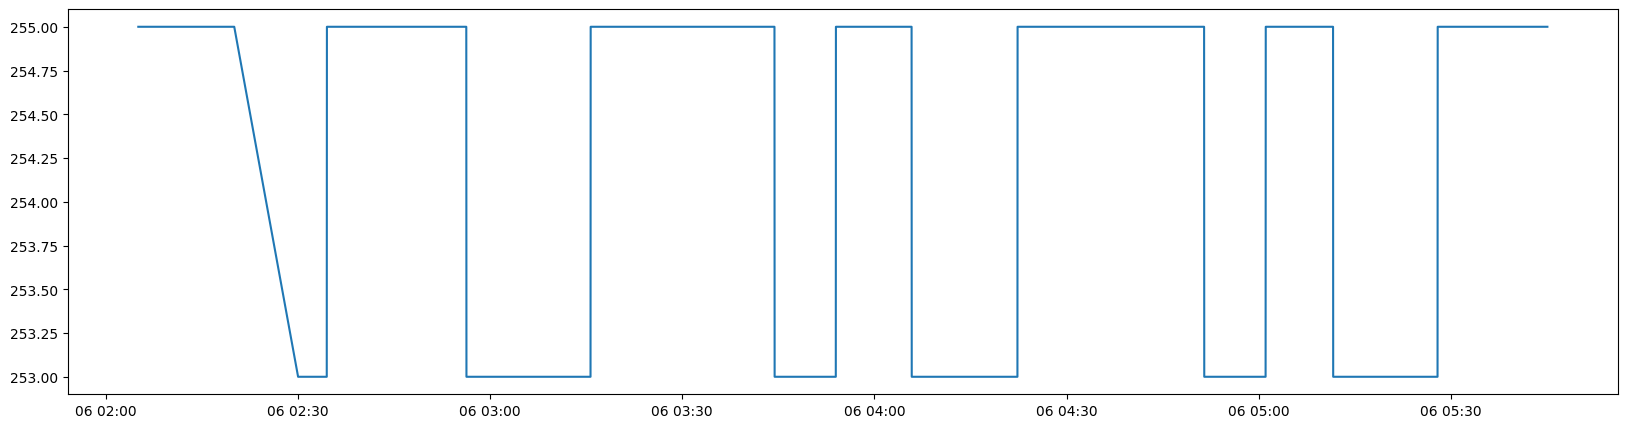

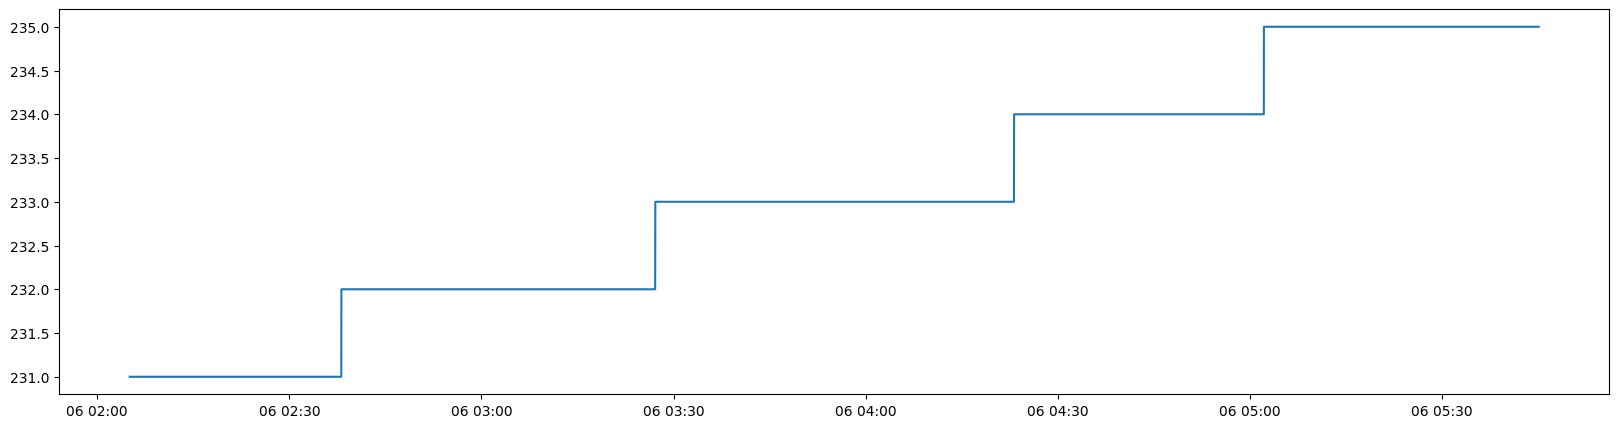

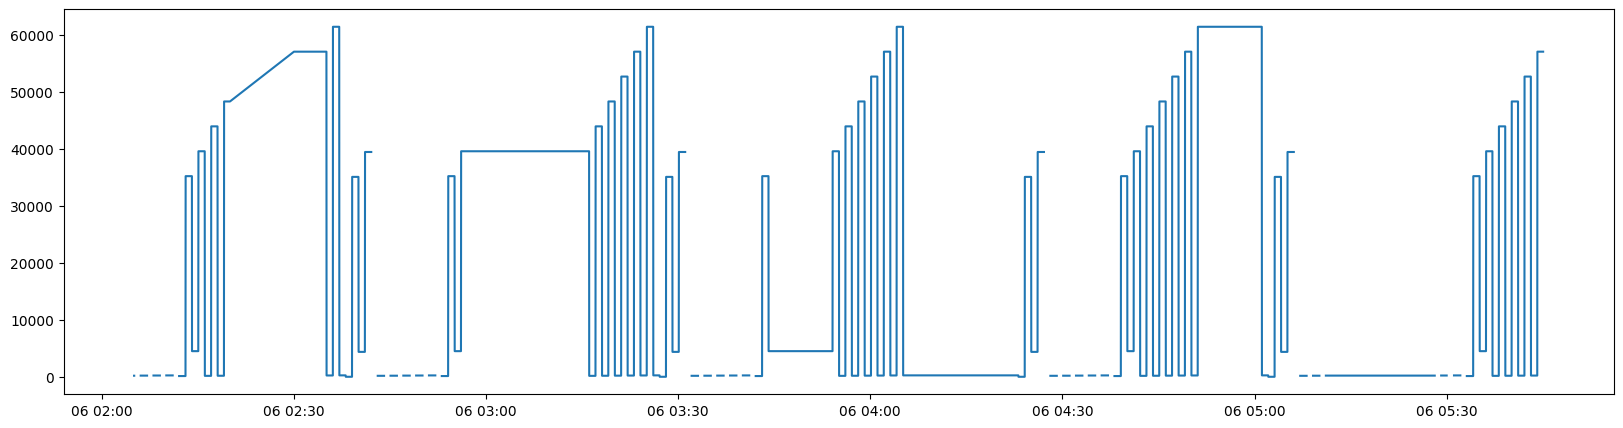

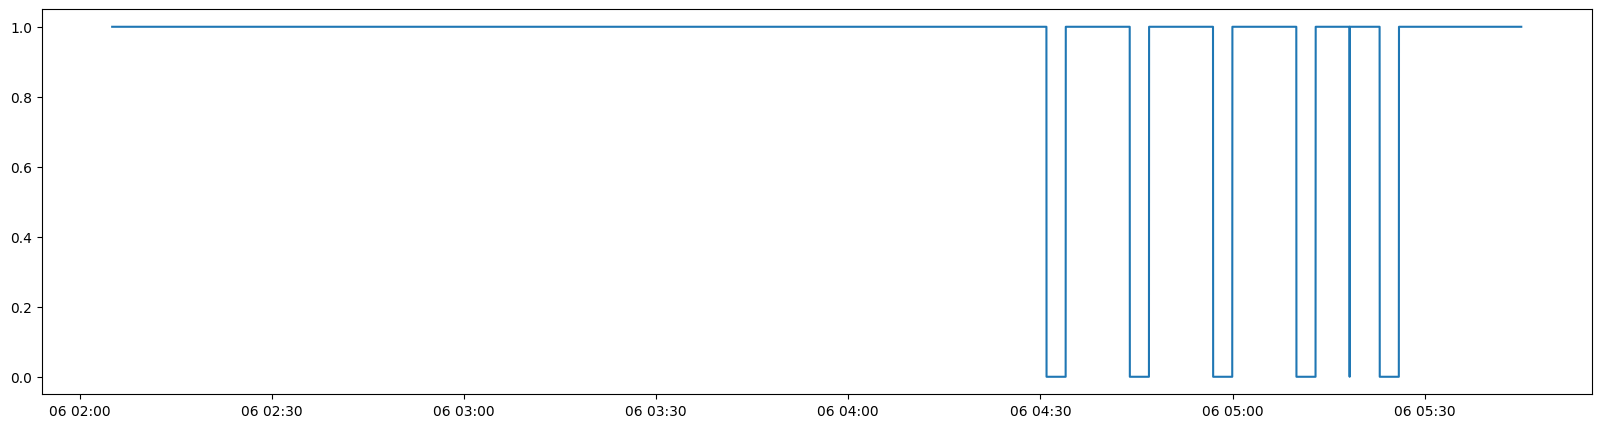

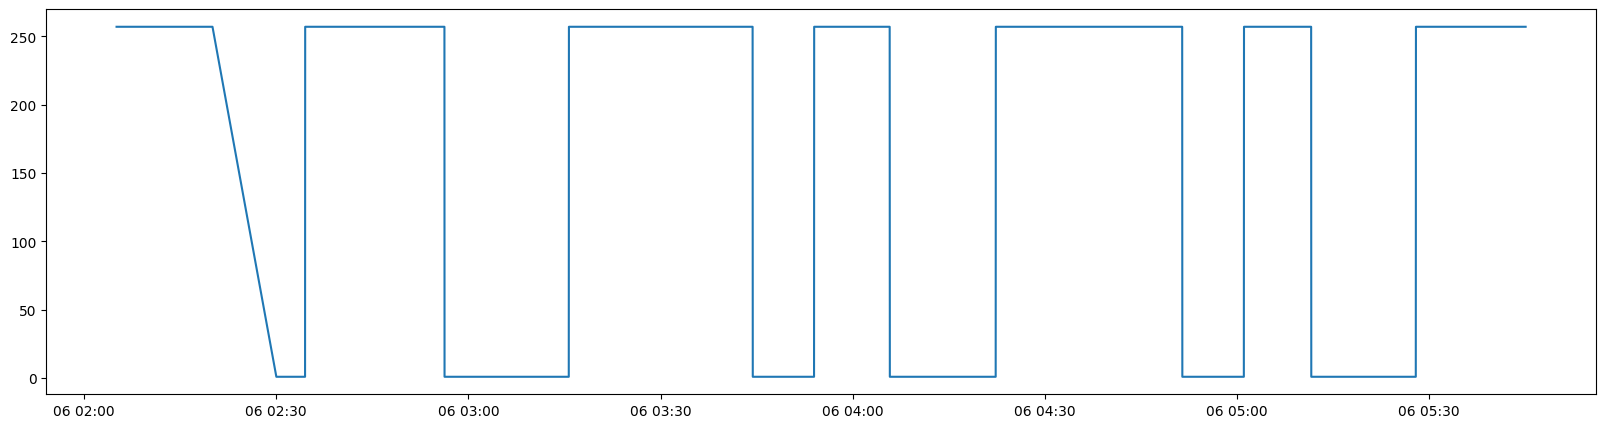

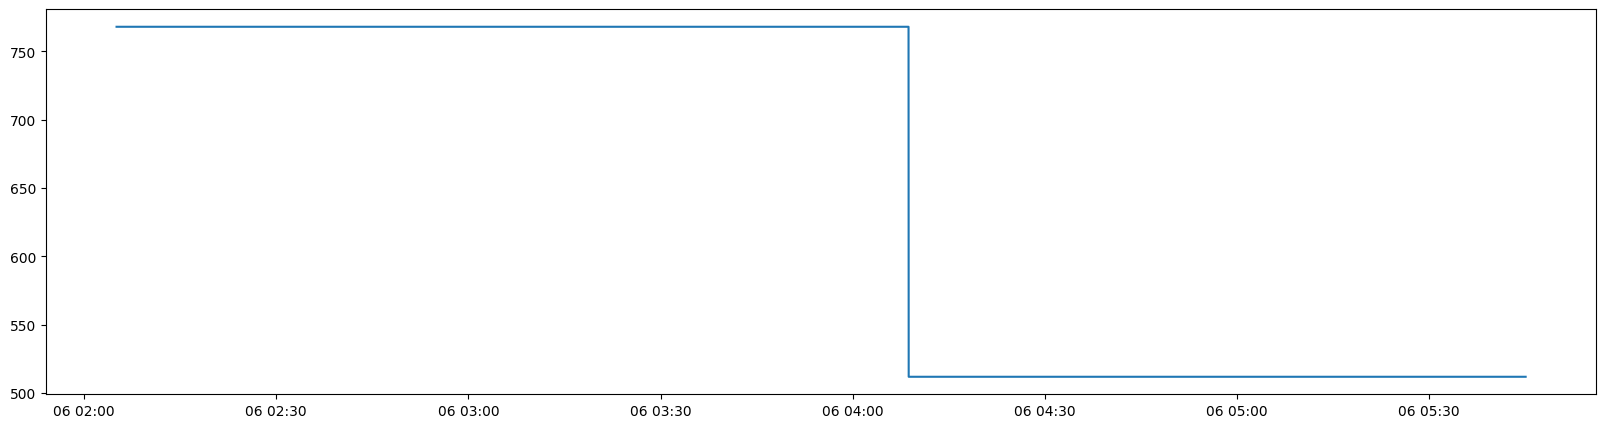

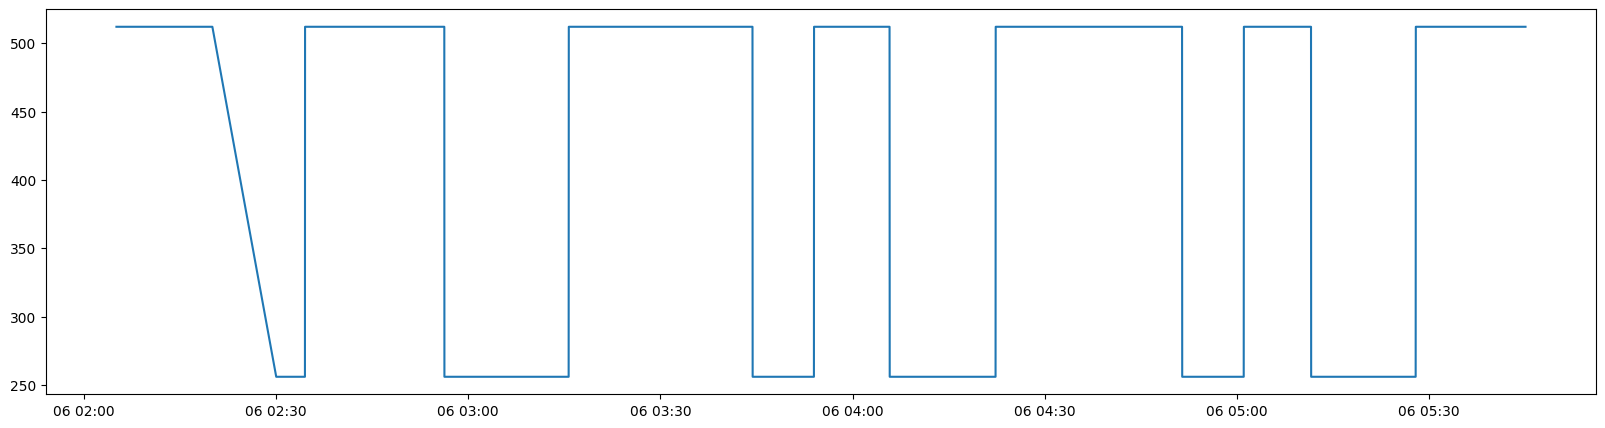

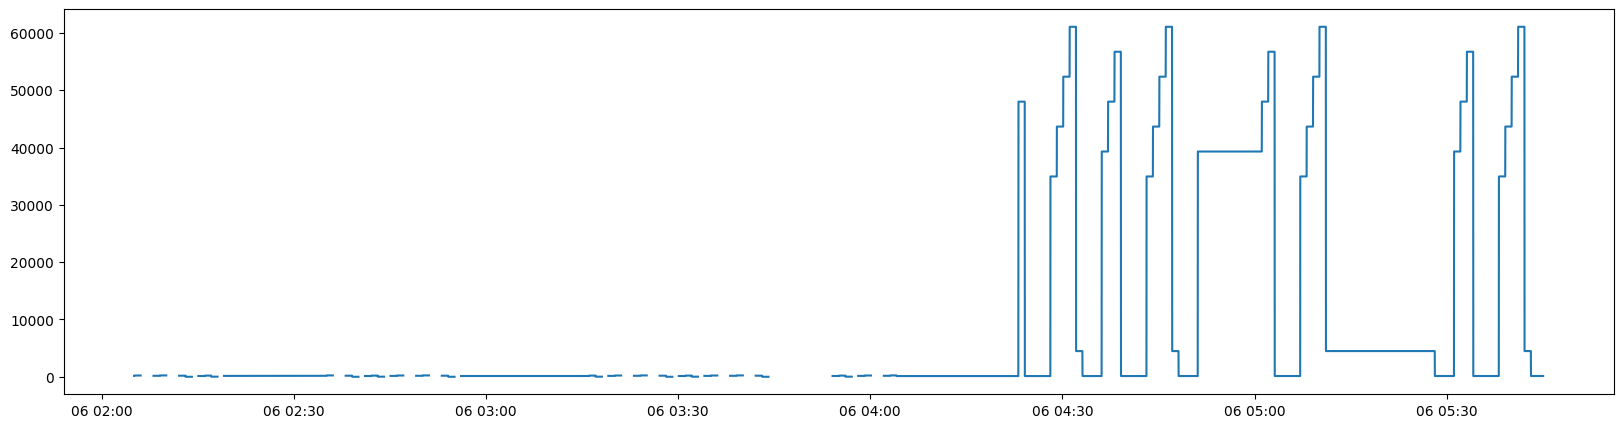

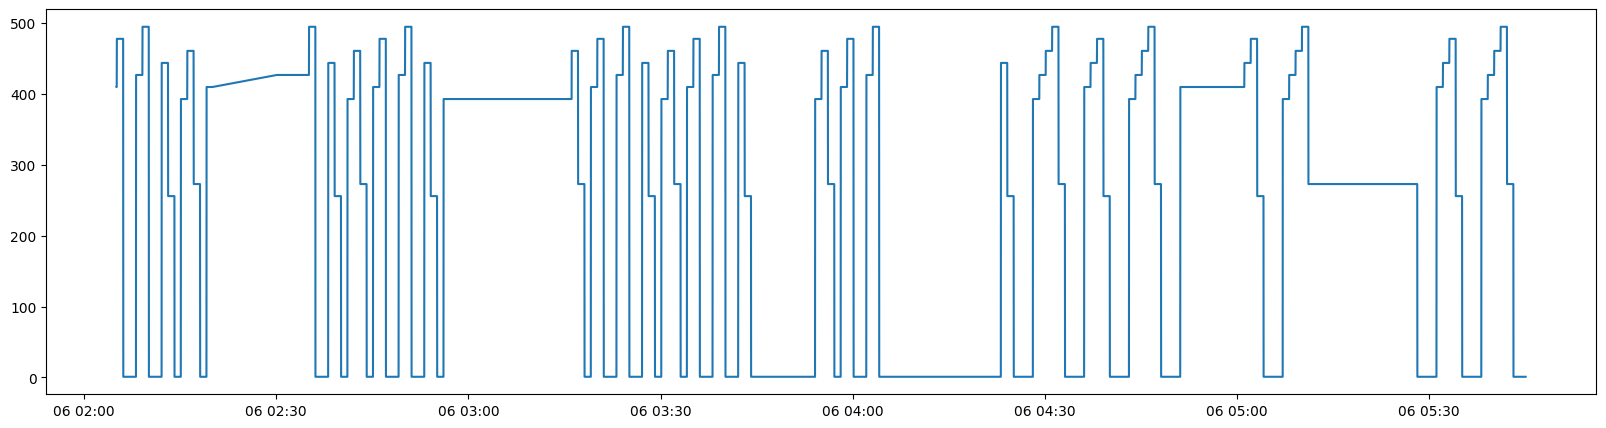

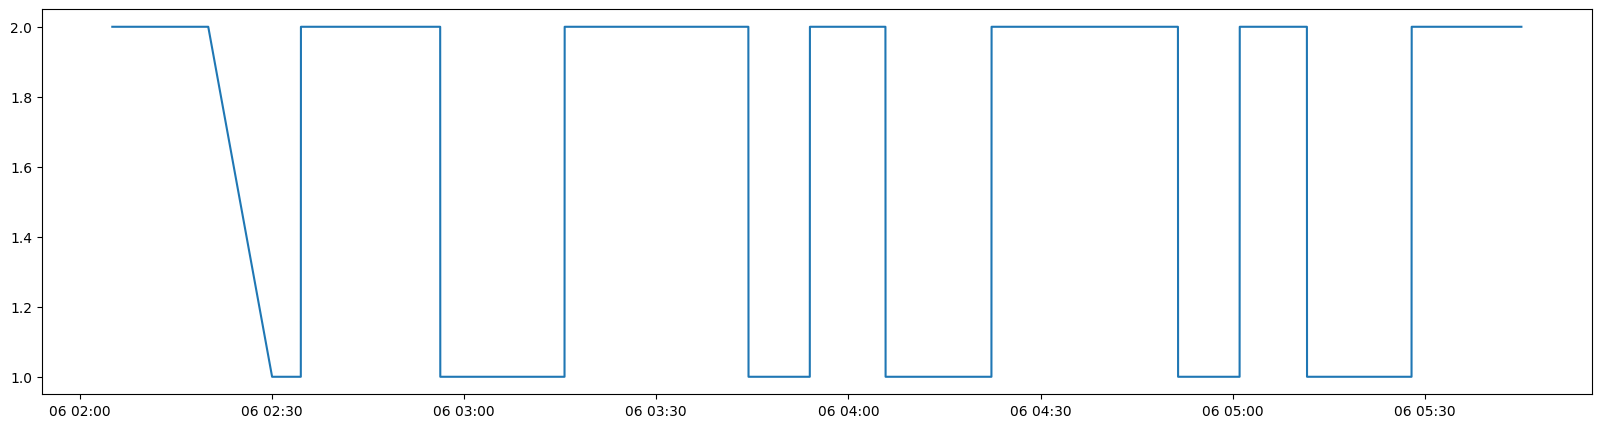

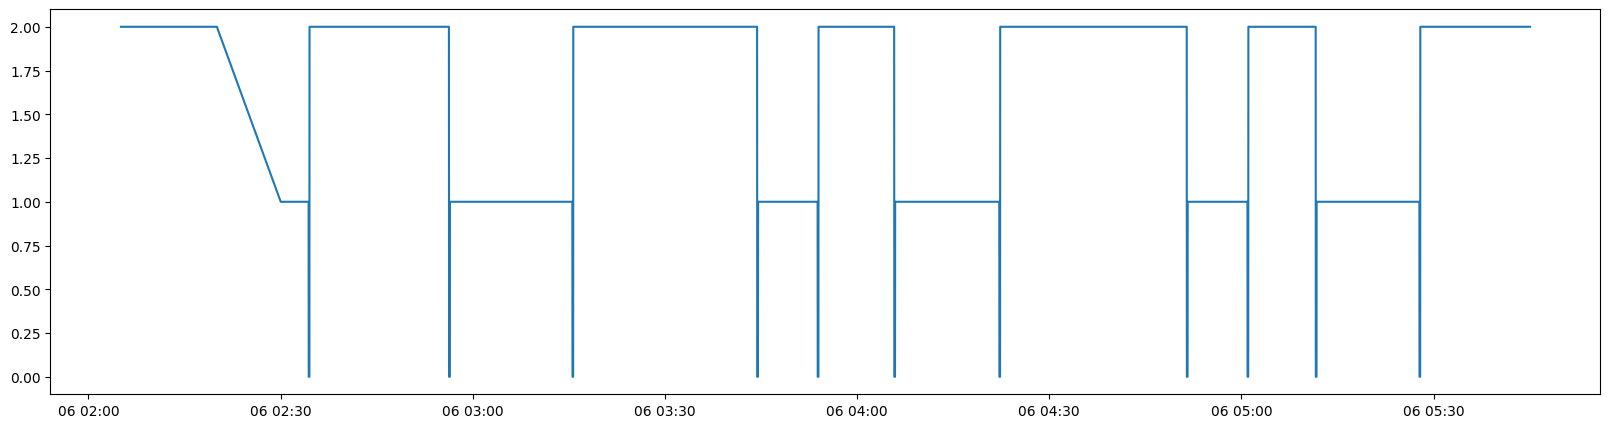

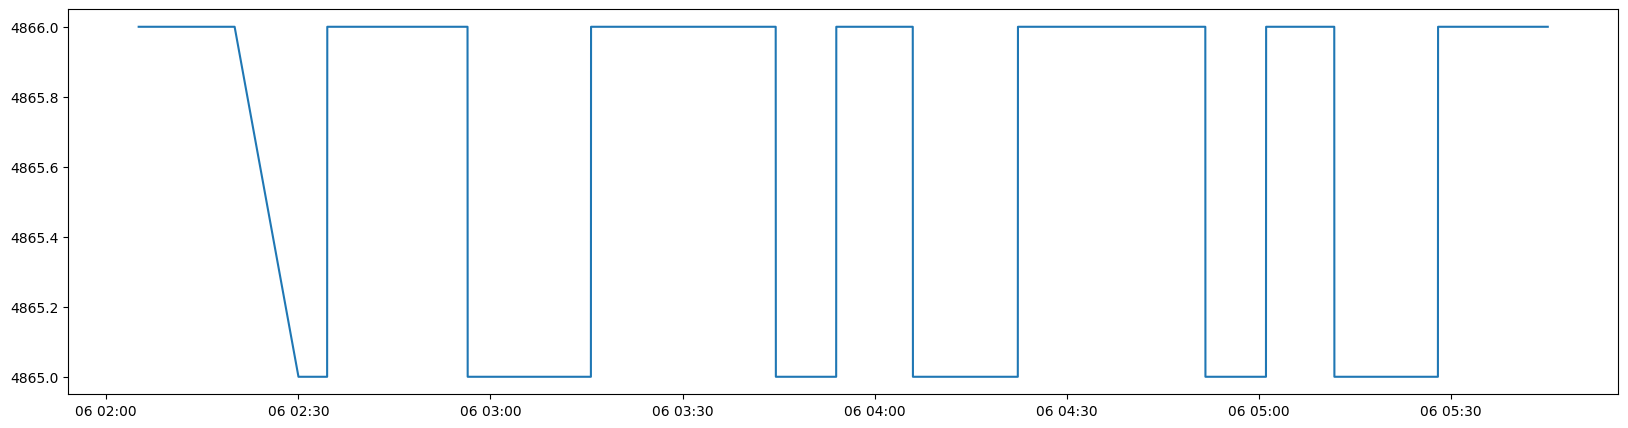

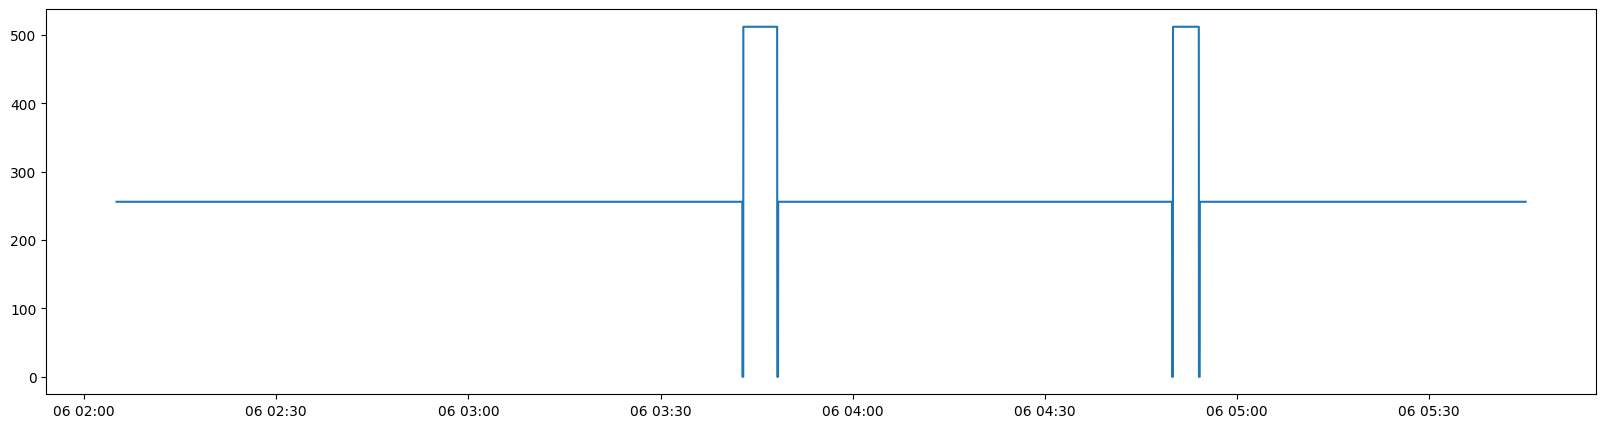

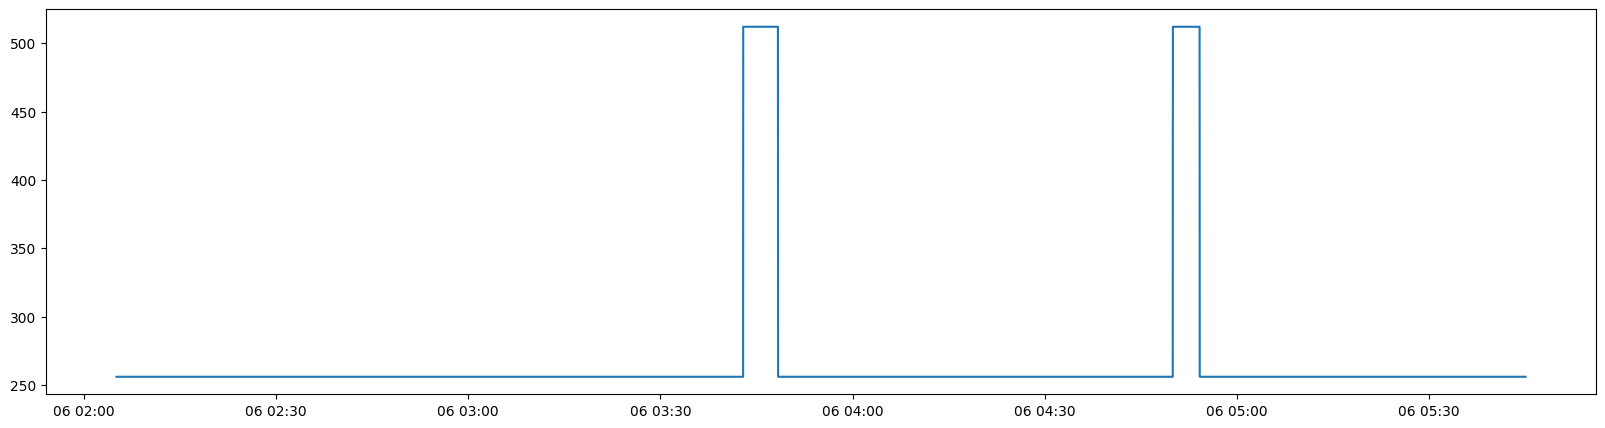

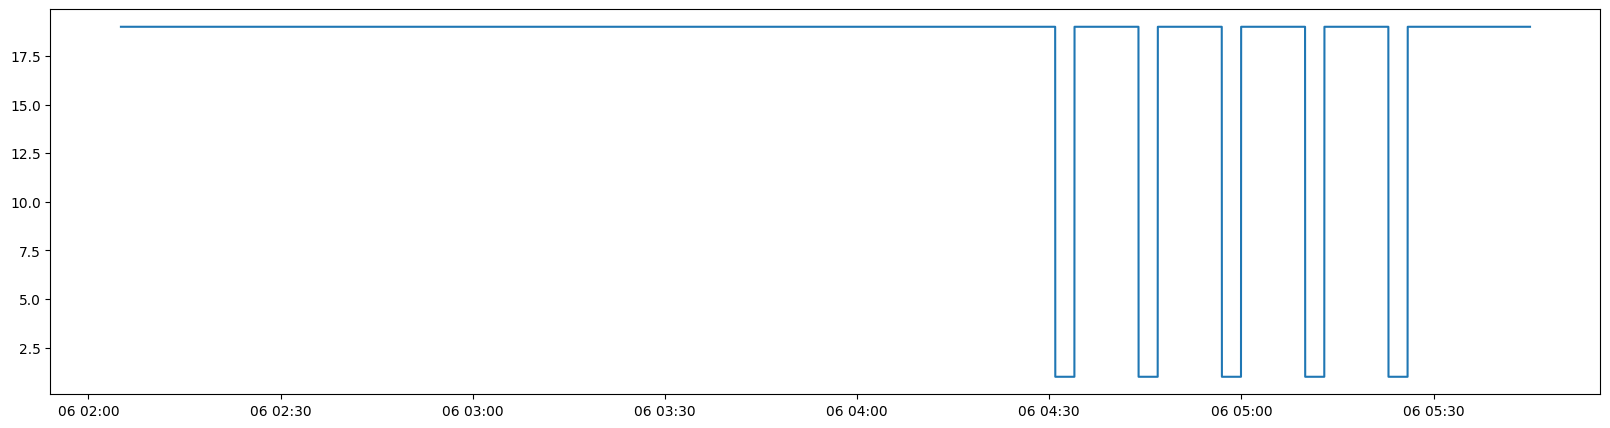

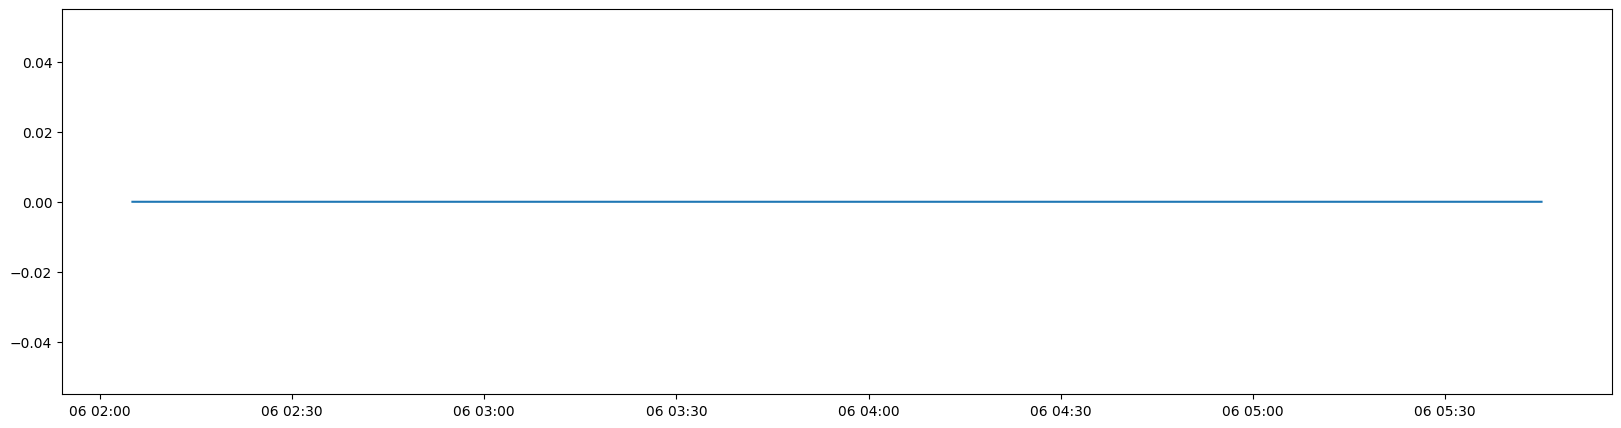

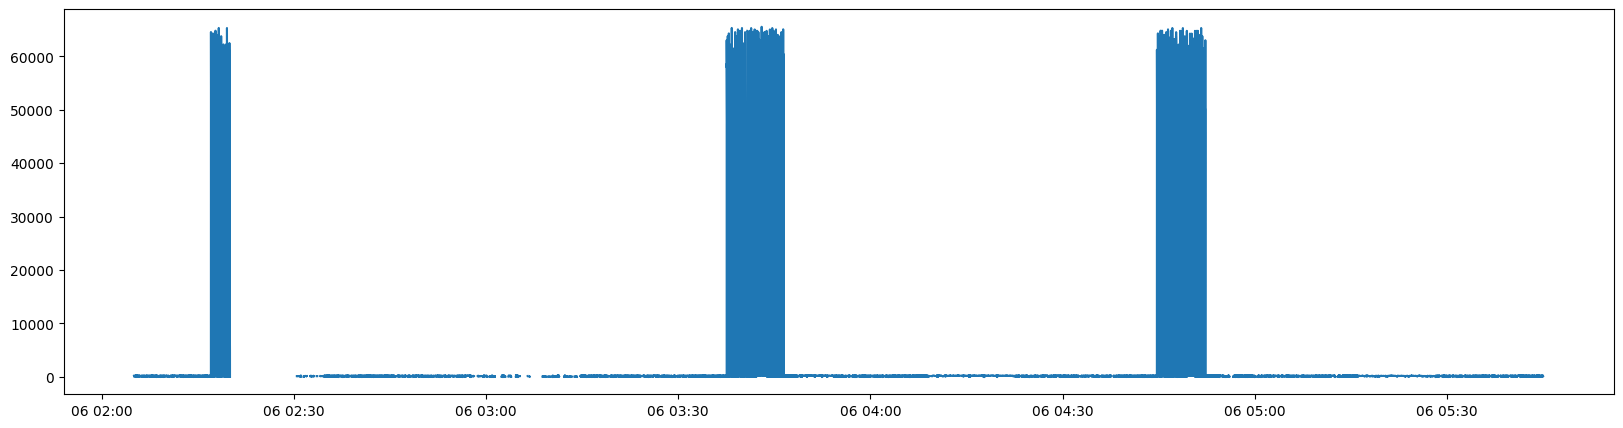

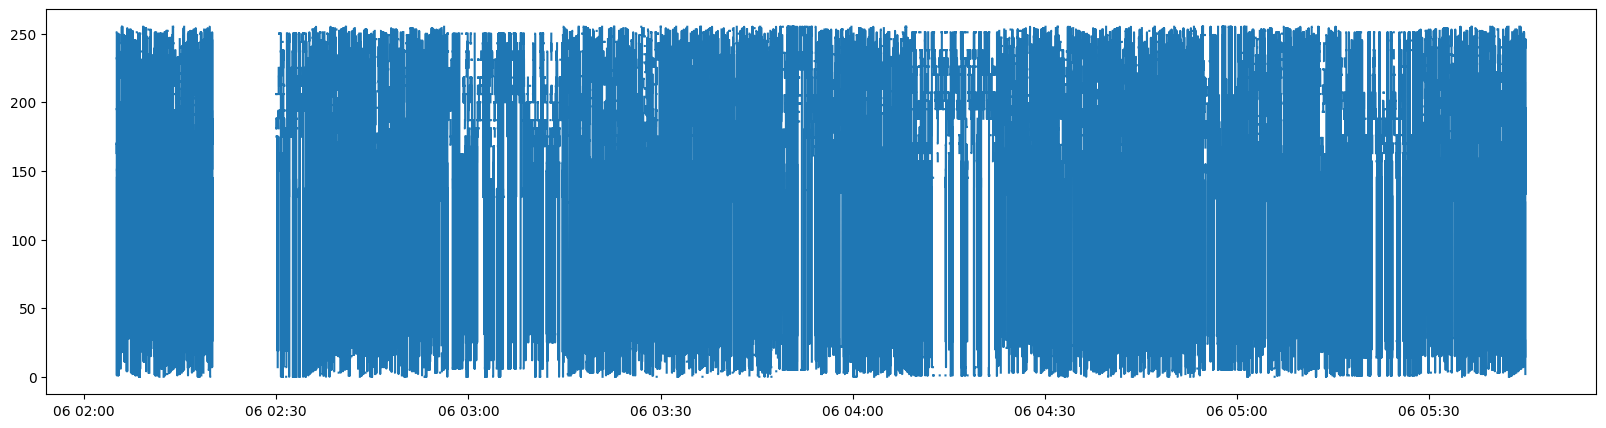

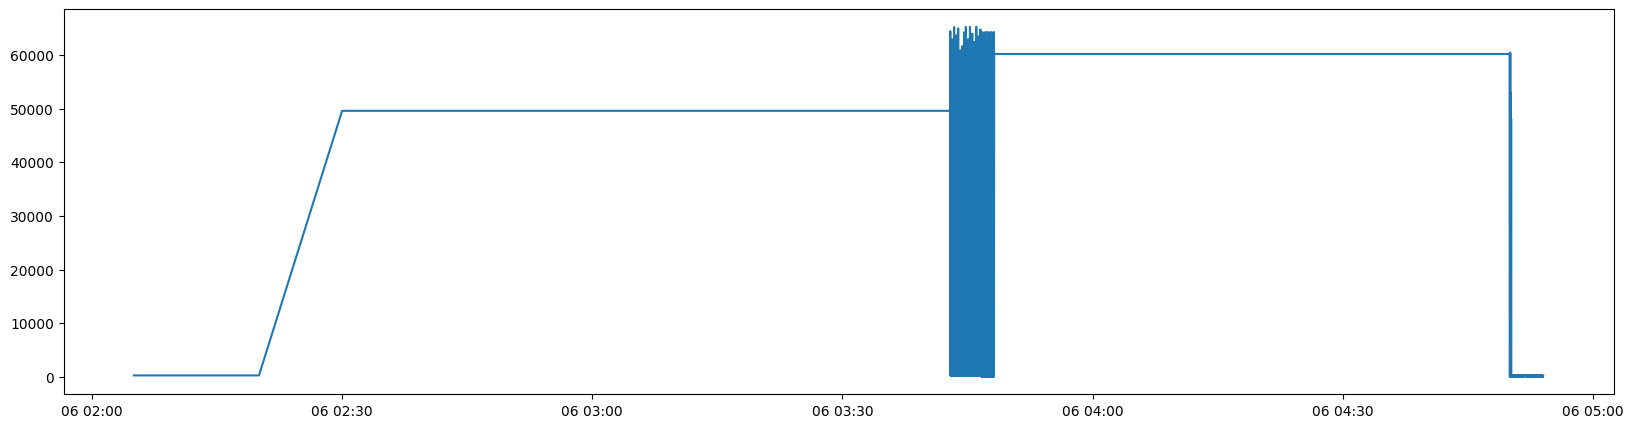

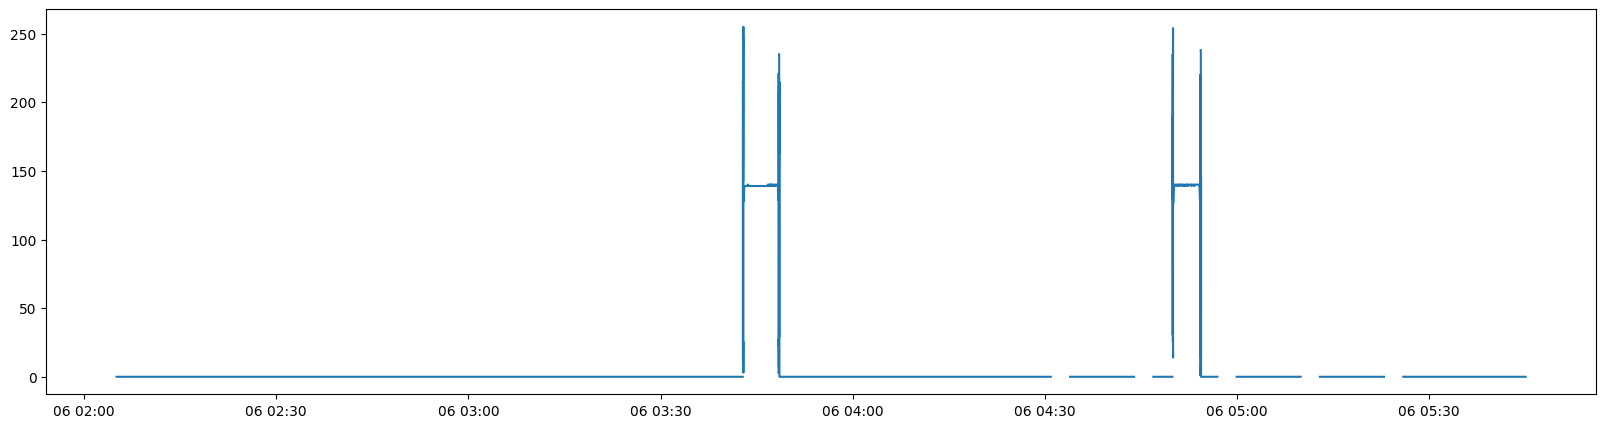

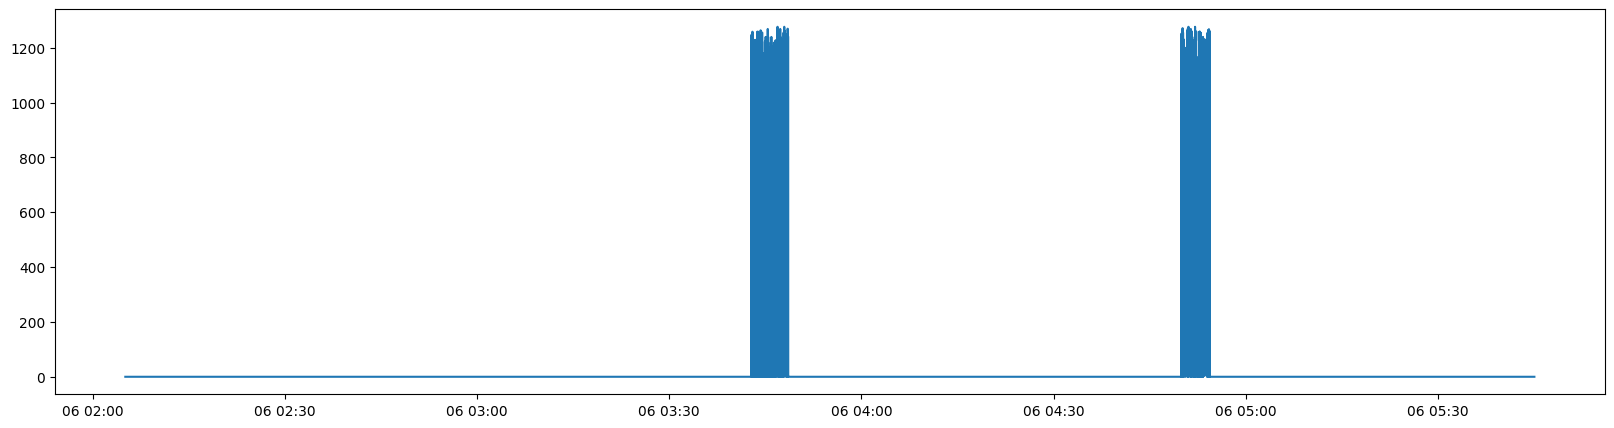

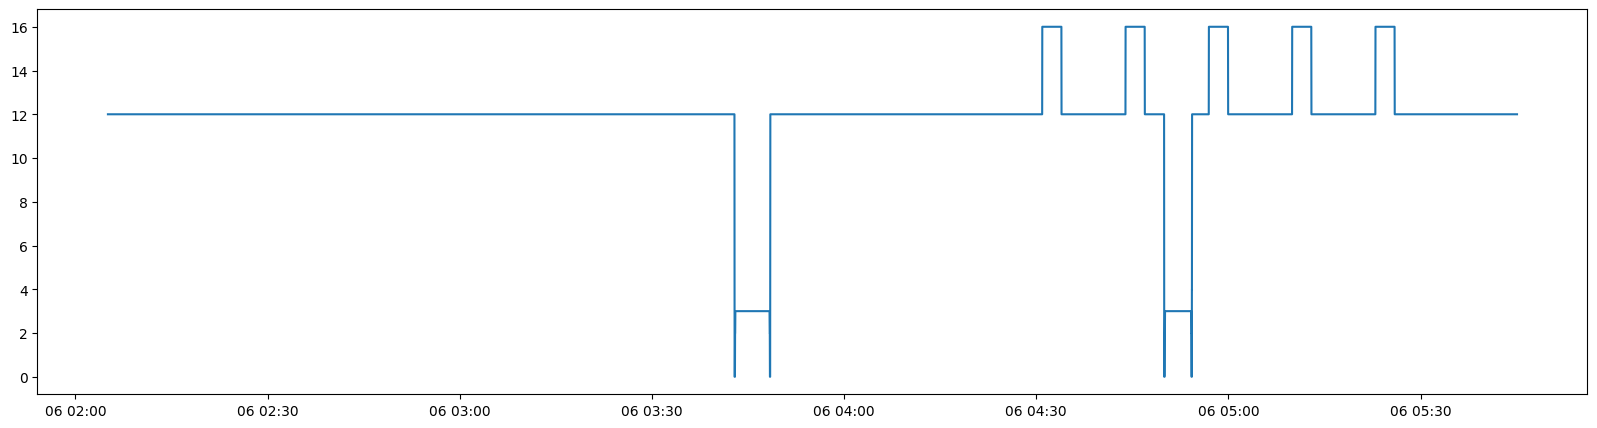

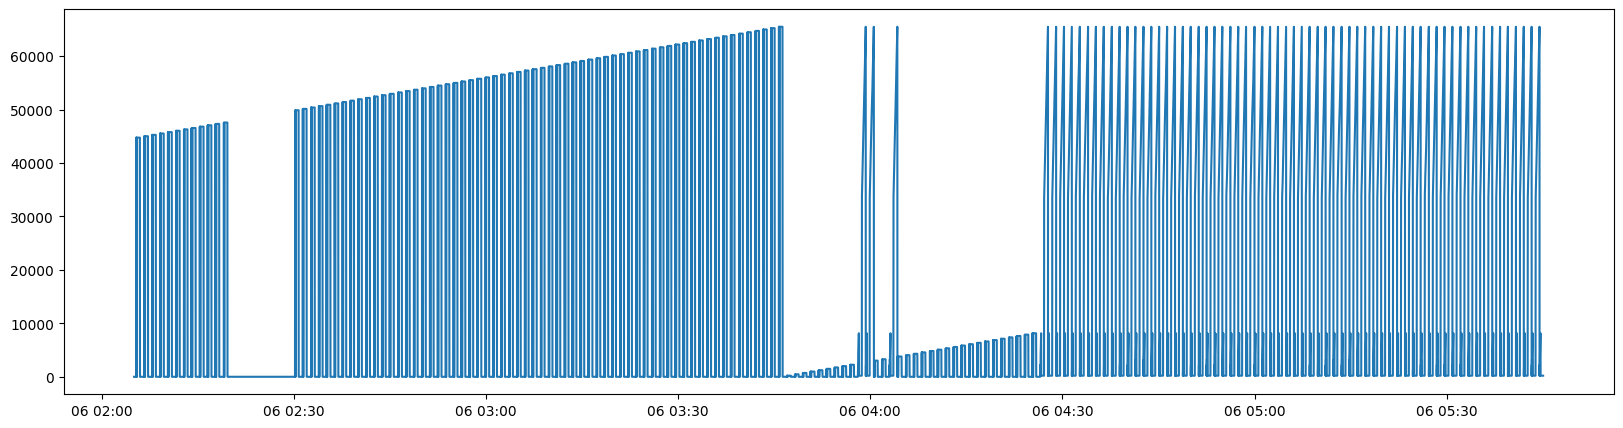

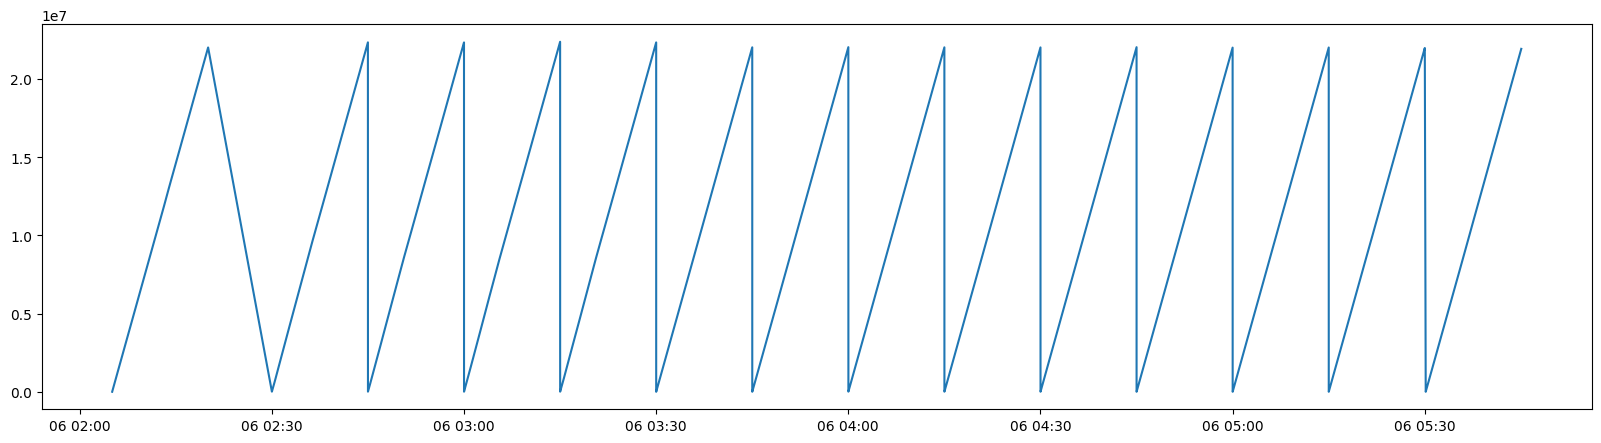

In [342]:
for col in df_bytes_converted.columns:
    plt.figure(figsize=(20,5))
    plt.plot(df_bytes_converted[col])
    plt.show()

In [358]:
df_train = df_bytes_converted.loc[:'2019-12-06 04:30:00'].copy().fillna(method='ffill')
df_train_id = df_train.pop('id')
df_train.head(3)

,5,7,8,19,21,22,30,32,33,35,...,40,41,51,52,53,56,66,67,68,80
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-12-06 02:05:04.415631056,255,231,188.0,1,257,768,512,153.0,410,2,...,256,19,0,240.0,170.0,253.0,0.0,-1,12,-1
2019-12-06 02:05:04.415632010,255,231,188.0,1,257,768,512,153.0,410,2,...,256,19,0,240.0,170.0,253.0,0.0,-1,12,-1
2019-12-06 02:05:04.532814026,255,231,188.0,1,257,768,512,153.0,410,2,...,256,19,0,235.0,163.0,253.0,0.0,-1,12,-1


In [350]:
anomaly_idxs = [['2019-12-06 04:30:55', '2019-12-06 04:33:55'],
                ['2019-12-06 04:43:55', '2019-12-06 04:46:55'],
                ['2019-12-06 04:56:55', '2019-12-06 04:59:55'], 
                ['2019-12-06 05:09:55', '2019-12-06 05:12:55'], 
                ['2019-12-06 05:22:55', '2019-12-06 05:25:55']]

In [366]:
df_test = df_bytes_converted.loc['2019-12-06 04:30:00':].copy().fillna(method='ffill').fillna(method='bfill')
df_test_id = df_test.pop('id')

df_test['anomaly'] = 0

for idx in anomaly_idxs:
    df_test['anomaly'].loc[idx[0]:idx[1]] = 1

df_test.head(3)

/opt/python37/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,5,7,8,19,21,22,30,32,33,35,...,41,51,52,53,56,66,67,68,80,anomaly
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-12-06 04:30:00.014081001,255,234,188.0,1,257,512,512,43648.0,427,2,...,19,0,190.0,161.0,60188.0,0.0,-1,12,51916,0
2019-12-06 04:30:00.014082909,255,234,188.0,1,257,512,512,43648.0,427,2,...,19,0,190.0,161.0,60188.0,0.0,-1,12,51916,0
2019-12-06 04:30:00.518059968,255,234,188.0,1,257,512,512,43648.0,427,2,...,19,0,155.0,161.0,60188.0,0.0,-1,12,52172,0


In [360]:
summary = {}

## Подготовка train/test

In [370]:
x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy())

Scaling... (Standard)
Количество аномалий: 20.1%

Counter({0: 23968, 1: 6034})
Размеры выборок:
            x_train: (54406, 23)
            x_test: (30002, 23)
            y_test: (30002,)


## OC SVM

In [371]:
description='SWATDec19_svm_default'

model = OCSVM()
predictor = Predictor(model, [x_train, x_test, y_test], descr=description, resave_model=True)

2022-09-03 22:55:53.027729: refit model...


In [372]:
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()

SWATDec19_svm_default
f1_score: 0.63
accuracy_score: 0.76
precision_score: 0.46
recall_score: 1.00


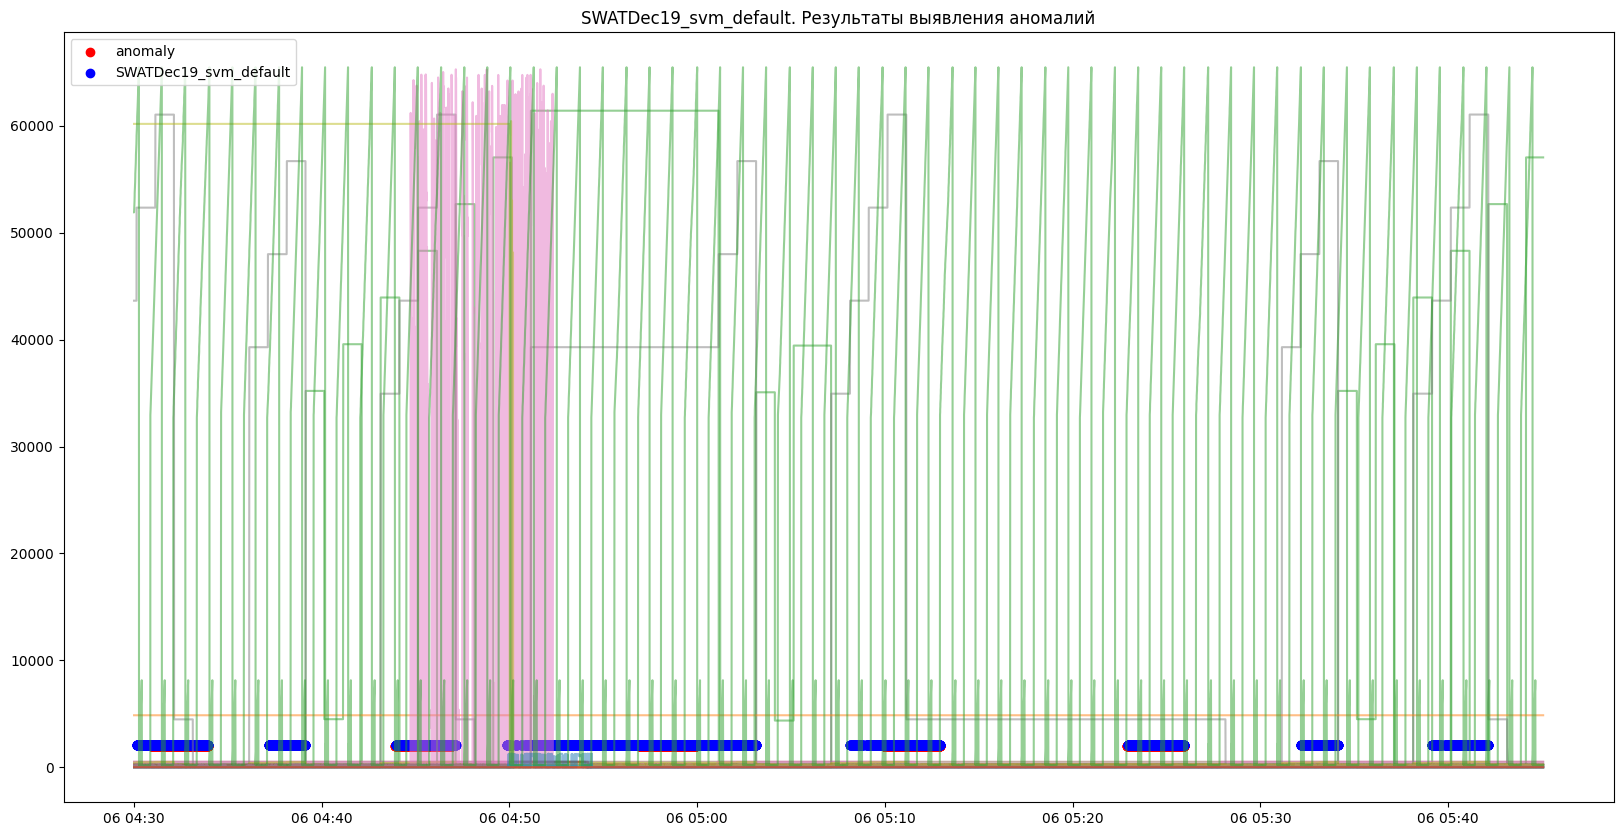

In [373]:
plot_result(df_test, y_test, y_pred, descr=description)

Scaling... (MinMax)
Количество аномалий: 20.1%

Counter({0: 23968, 1: 6034})
Размеры выборок:
            x_train: (54406, 23)
            x_test: (30002, 23)
            y_test: (30002,)
2022-09-03 22:56:56.655165: can't find saved model, fit model...
SWATDec19_svm_minmax
f1_score: 0.47
accuracy_score: 0.54
precision_score: 0.30
recall_score: 1.00


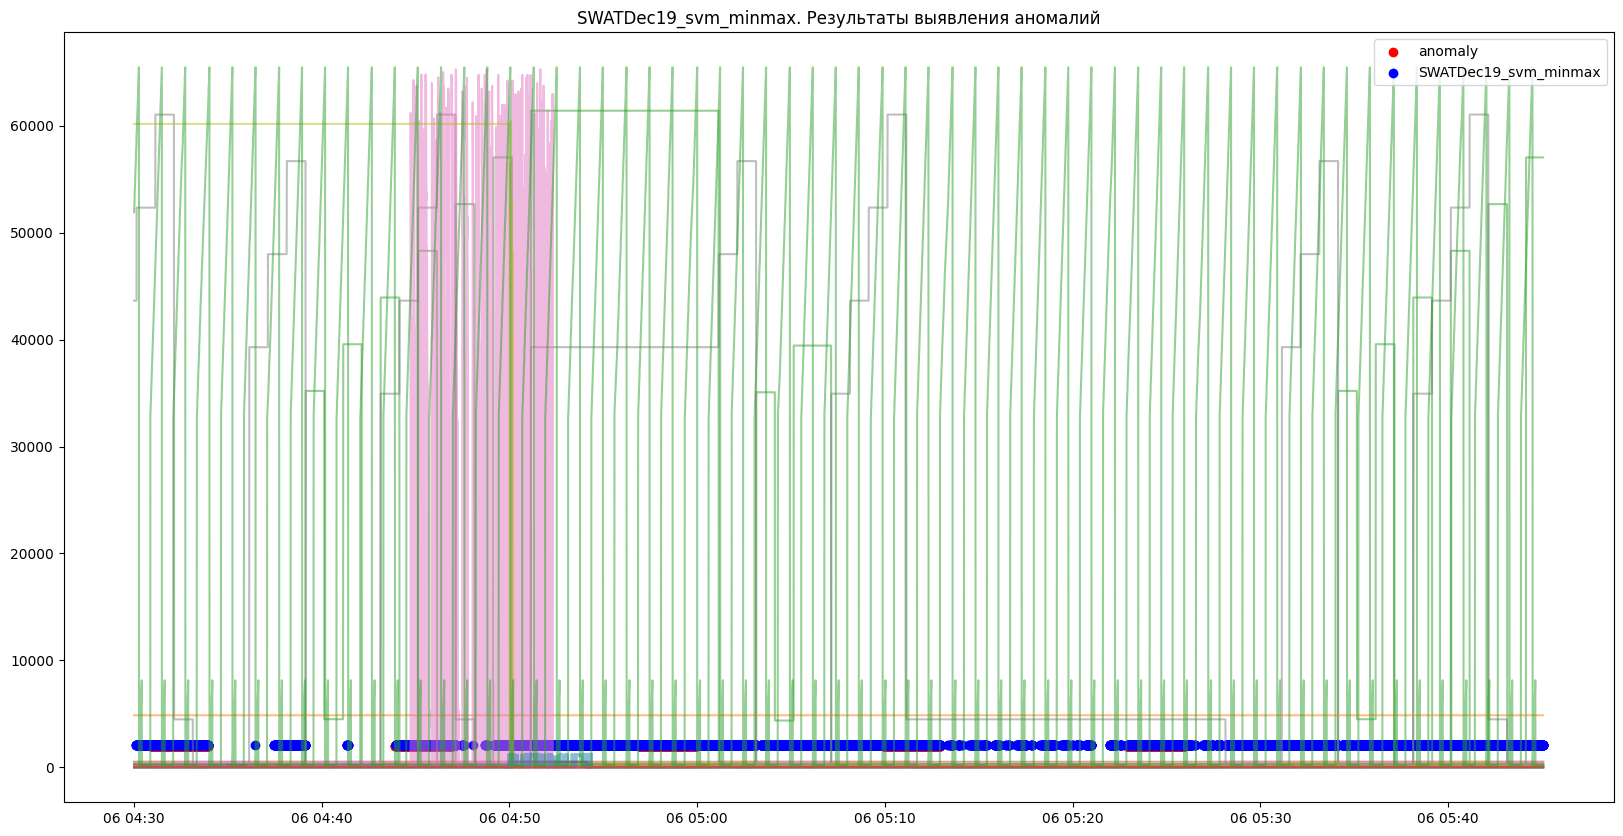

In [374]:
description='SWATDec19_svm_minmax'

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy(),
                                        scaler='MinMax')

predictor = Predictor(model, [x_train, x_test, y_test], descr=description)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## LOF

In [375]:
anomaly_idx = [i for i in range(len(y_test)) if y_test[i] == 1]

In [376]:
x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

Scaling... (Standard)
Количество аномалий: 20.1%

Counter({0: 23968, 1: 6034})
Размеры выборок:
            x_train: (54406, 23)
            x_test: (30002, 23)
            y_test: (30002,)


/opt/python37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


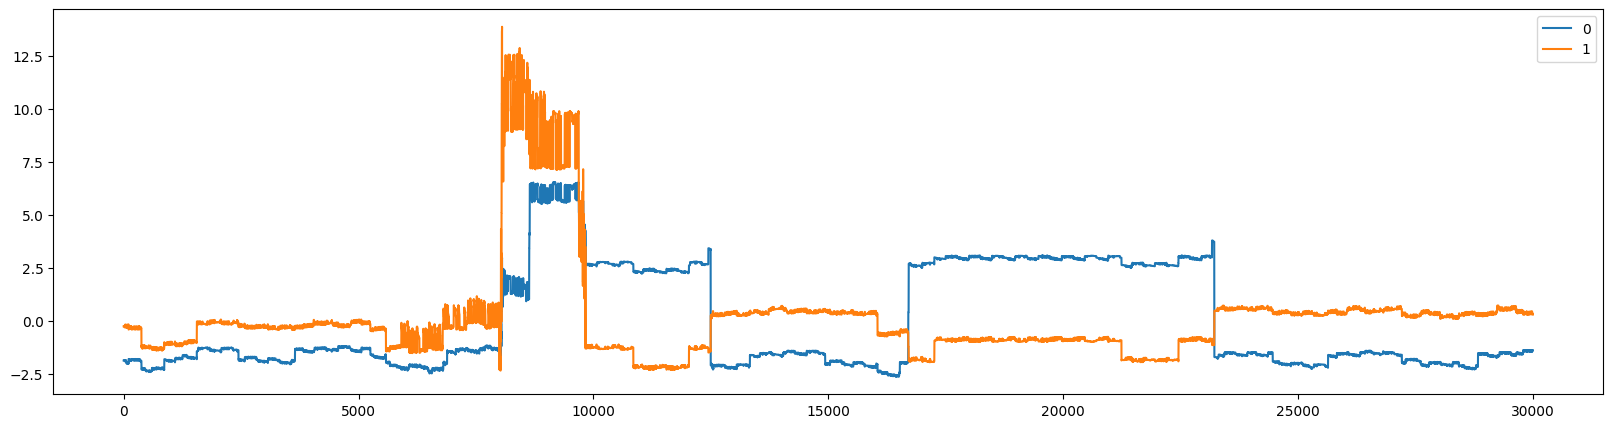

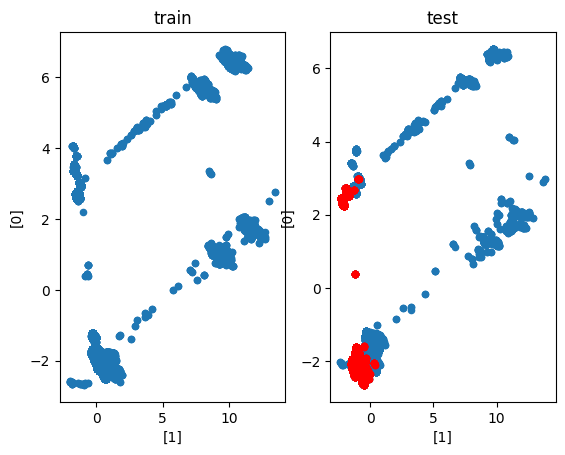

In [377]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit(x_train)

x_train_2d = pd.DataFrame(data = principalComponents.transform(x_train))
x_test_2d = pd.DataFrame(data = principalComponents.transform(x_test))
x_test_2d.plot(figsize=(20,5))

fig, (ax, ax_test) = plt.subplots(1, 2)
x_train_2d.plot.scatter(x=[1], y=[0], title='train', ax=ax)
x_test_2d.plot.scatter(x=[1], y=[0], title='test', ax=ax_test)
x_test_2d.iloc[anomaly_idx].plot.scatter(x=[1], y=[0], title='test', c='r', ax=ax_test)
plt.show()

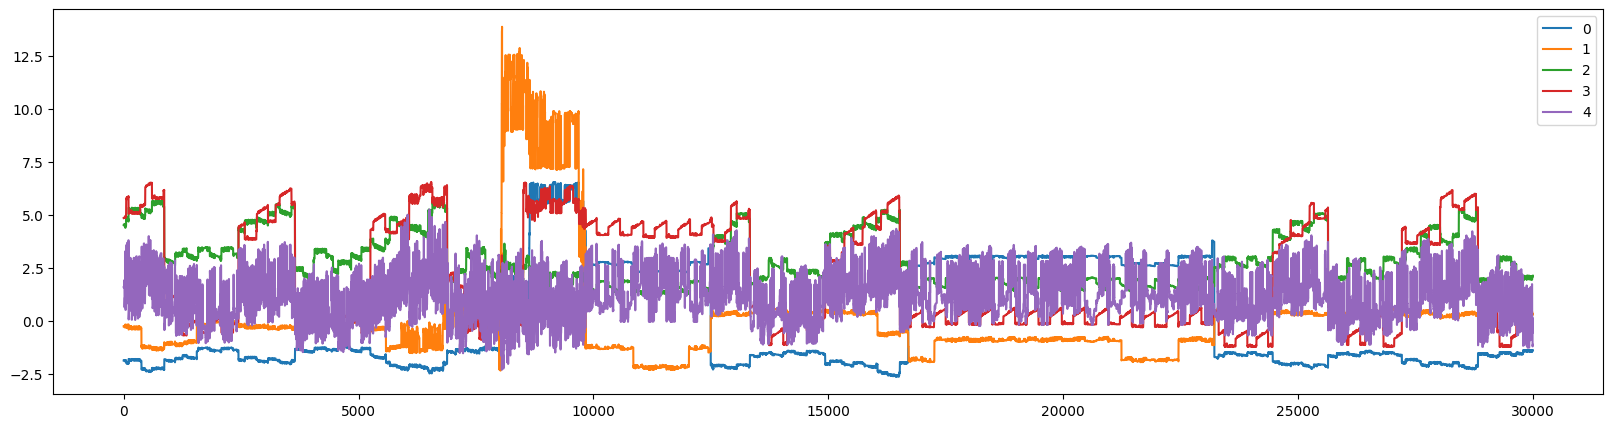

In [378]:
N_COMPONENTS = 5

pca = PCA(n_components=N_COMPONENTS)
principalComponents = pca.fit(x_train)

x_train_pca = pd.DataFrame(data = principalComponents.transform(x_train))
x_test_pca = pd.DataFrame(data = principalComponents.transform(x_test))
x_test_pca.plot(figsize=(20,5))
plt.show()

In [379]:
model = LOF()

2022-09-03 22:57:18.598999: refit model...
Train prediction score statistics
            min: -4908082780.767885
            mean: -1896078.2132616632
            max: -0.837886424035968


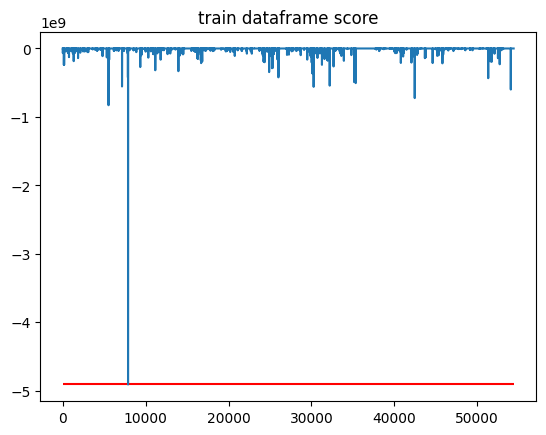

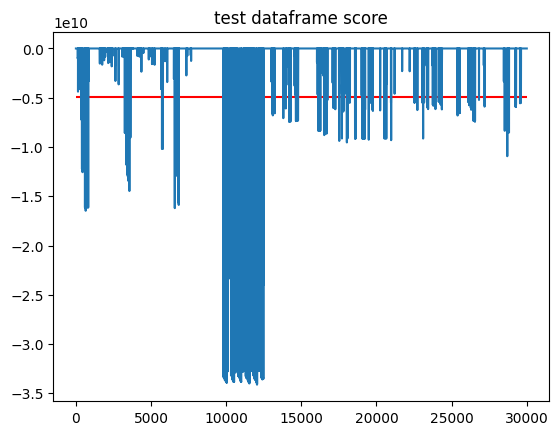

SWATDec19_lof_n5
f1_score: 0.27
accuracy_score: 0.80
precision_score: 0.50
recall_score: 0.18


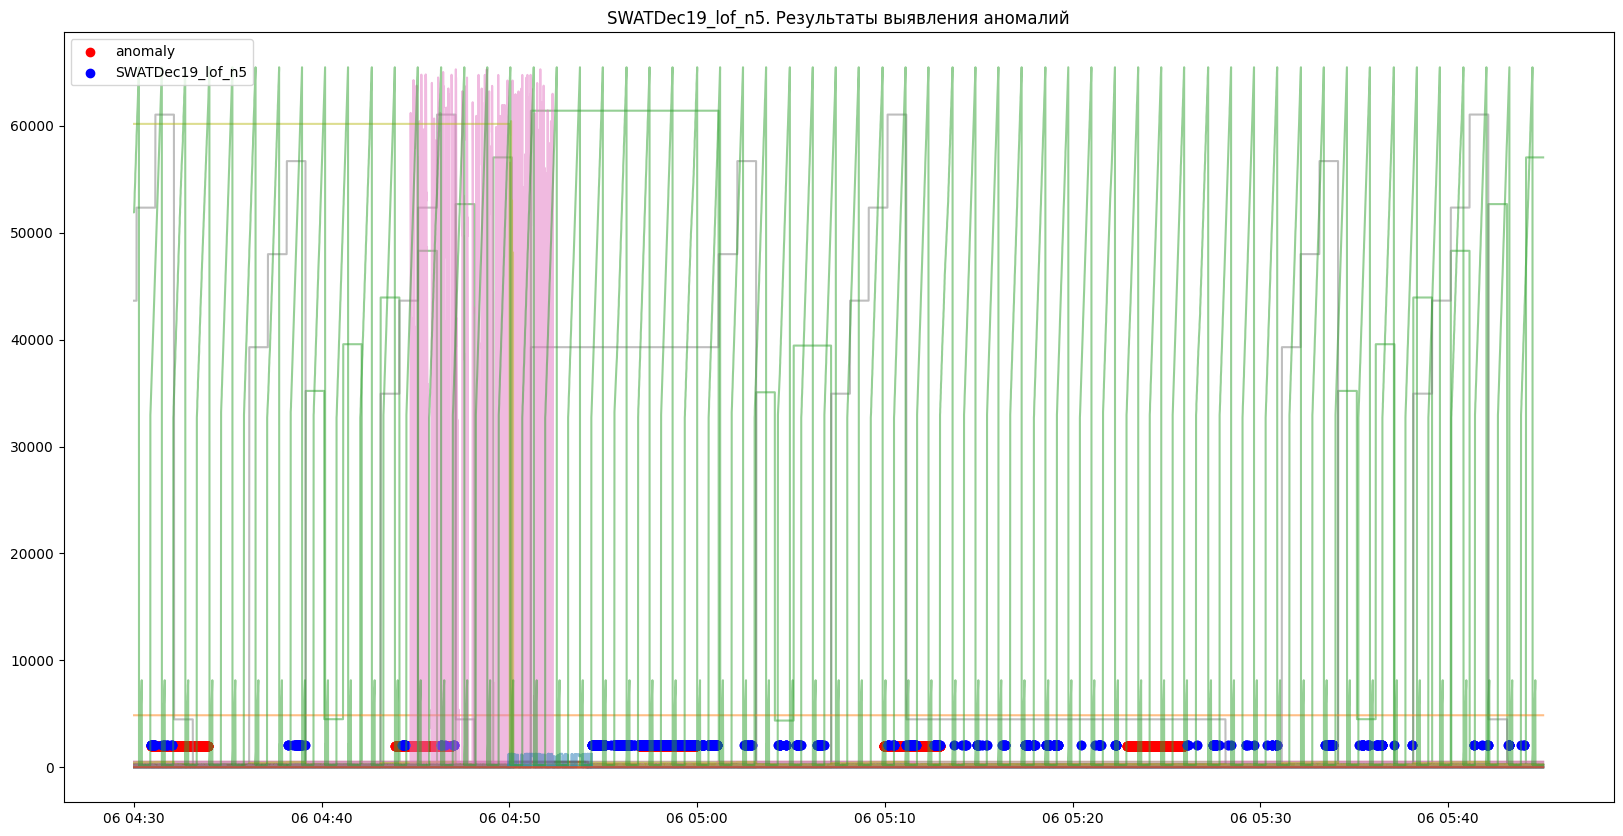

In [380]:
description = f'SWATDec19_lof_n{N_COMPONENTS}'
predictor = Predictor(model, [x_train_pca, x_test_pca, y_test], descr=description, resave_model=True)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

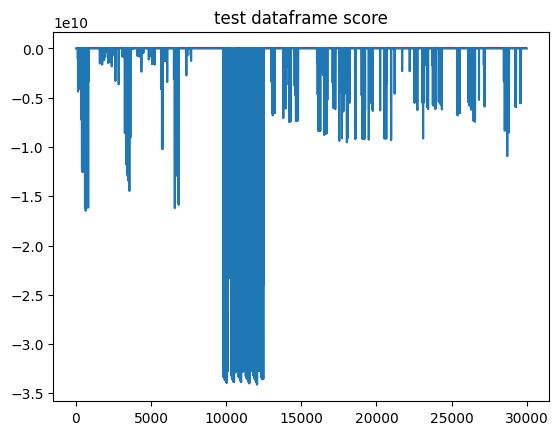

SWATDec19_lof_n5
f1_score: 0.34
accuracy_score: 0.20
precision_score: 0.20
recall_score: 1.00


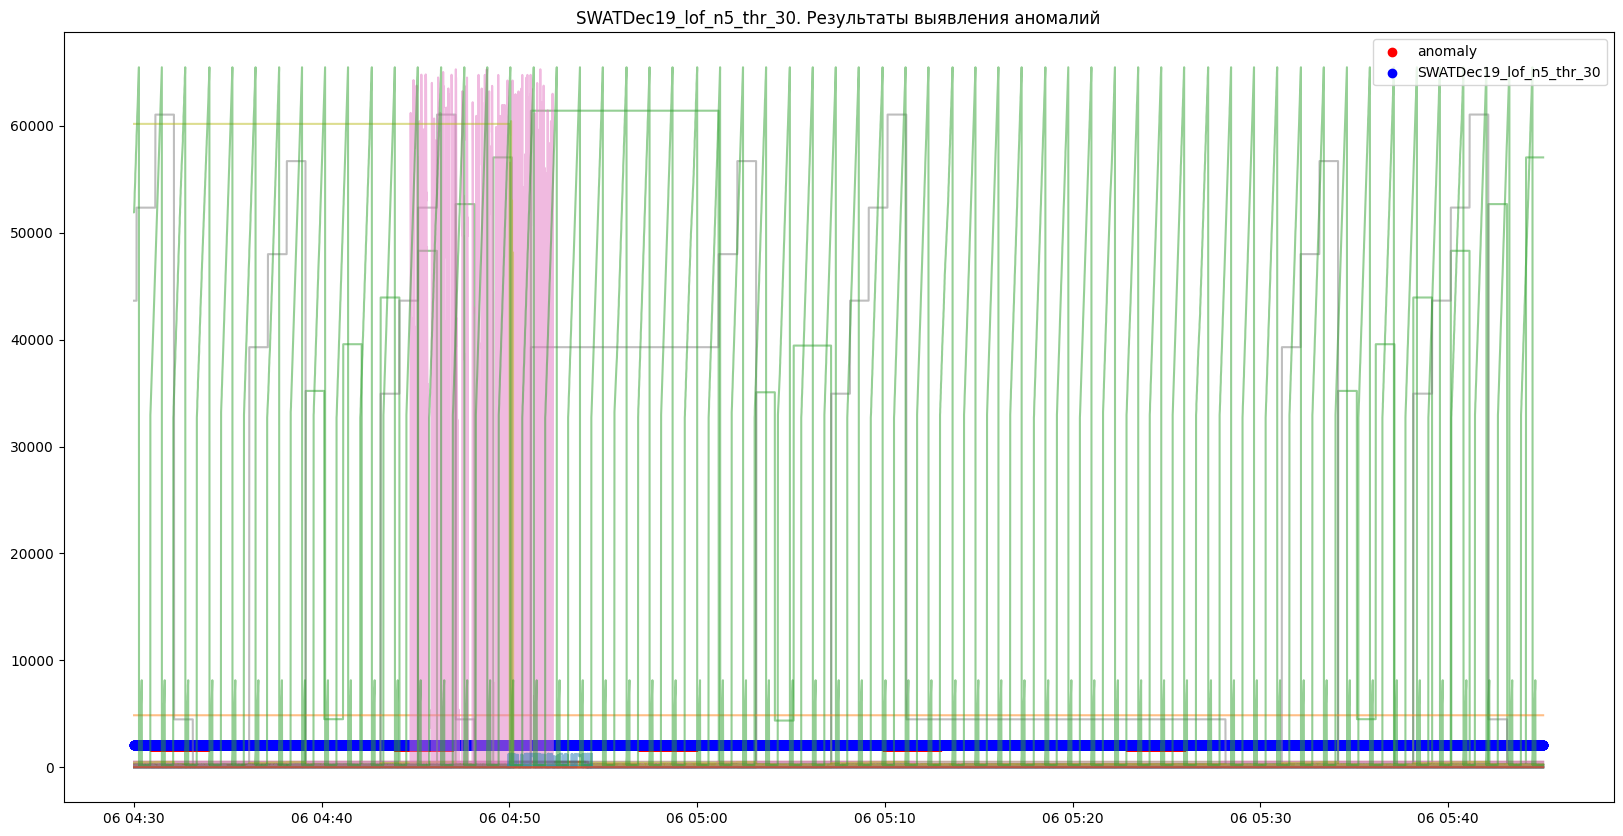

In [381]:
description = f'SWATDec19_lof_n{N_COMPONENTS}_thr_30'

y_pred = predictor.get_anomalies(threshold = -1)
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## iForest

Scaling... (Standard)
Количество аномалий: 20.1%

Counter({0: 23968, 1: 6034})
Размеры выборок:
            x_train: (54406, 23)
            x_test: (30002, 23)
            y_test: (30002,)
2022-09-03 22:58:56.654912: can't find saved model, fit model...
SWATDec19_iF_default
f1_score: 0.00
accuracy_score: 0.79
precision_score: 0.00
recall_score: 0.00


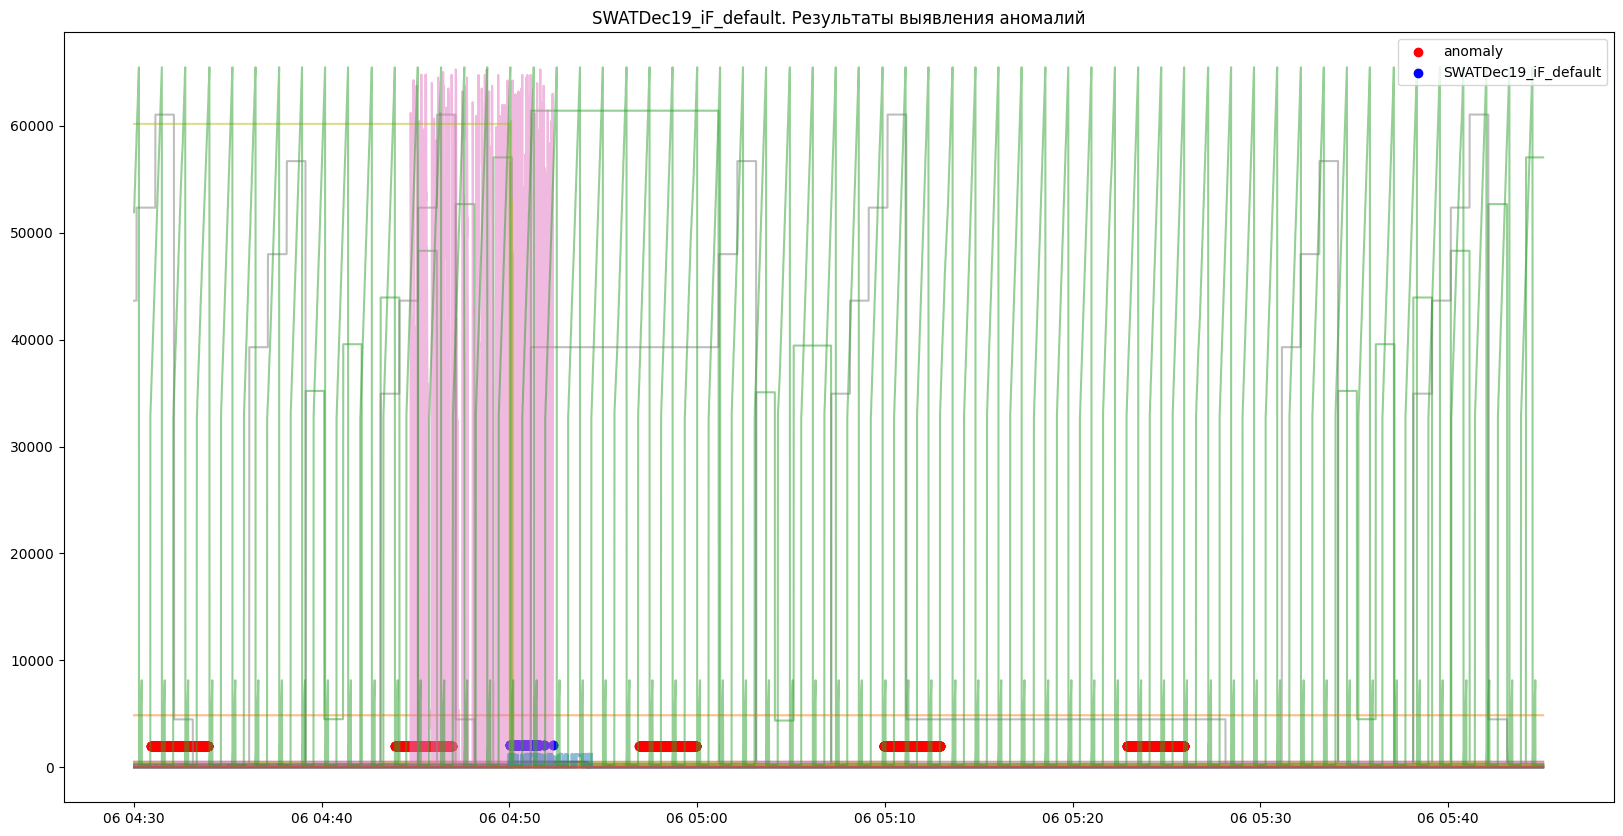

In [382]:
description = f'SWATDec19_iF_default'

x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy())

model = iForest()

predictor = Predictor(model, [x_train, x_test, y_test], descr=description, resave_model=False)
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

Scaling... (Standard)
Количество аномалий: 20.1%

Counter({0: 23968, 1: 6034})
Размеры выборок:
            x_train: (54406, 23)
            x_test: (30002, 23)
            y_test: (30002,)
2022-09-03 22:58:59.279270: refit model...
SWATDec19_iF_n_200_c_0005
f1_score: 0.00
accuracy_score: 0.77
precision_score: 0.00
recall_score: 0.00


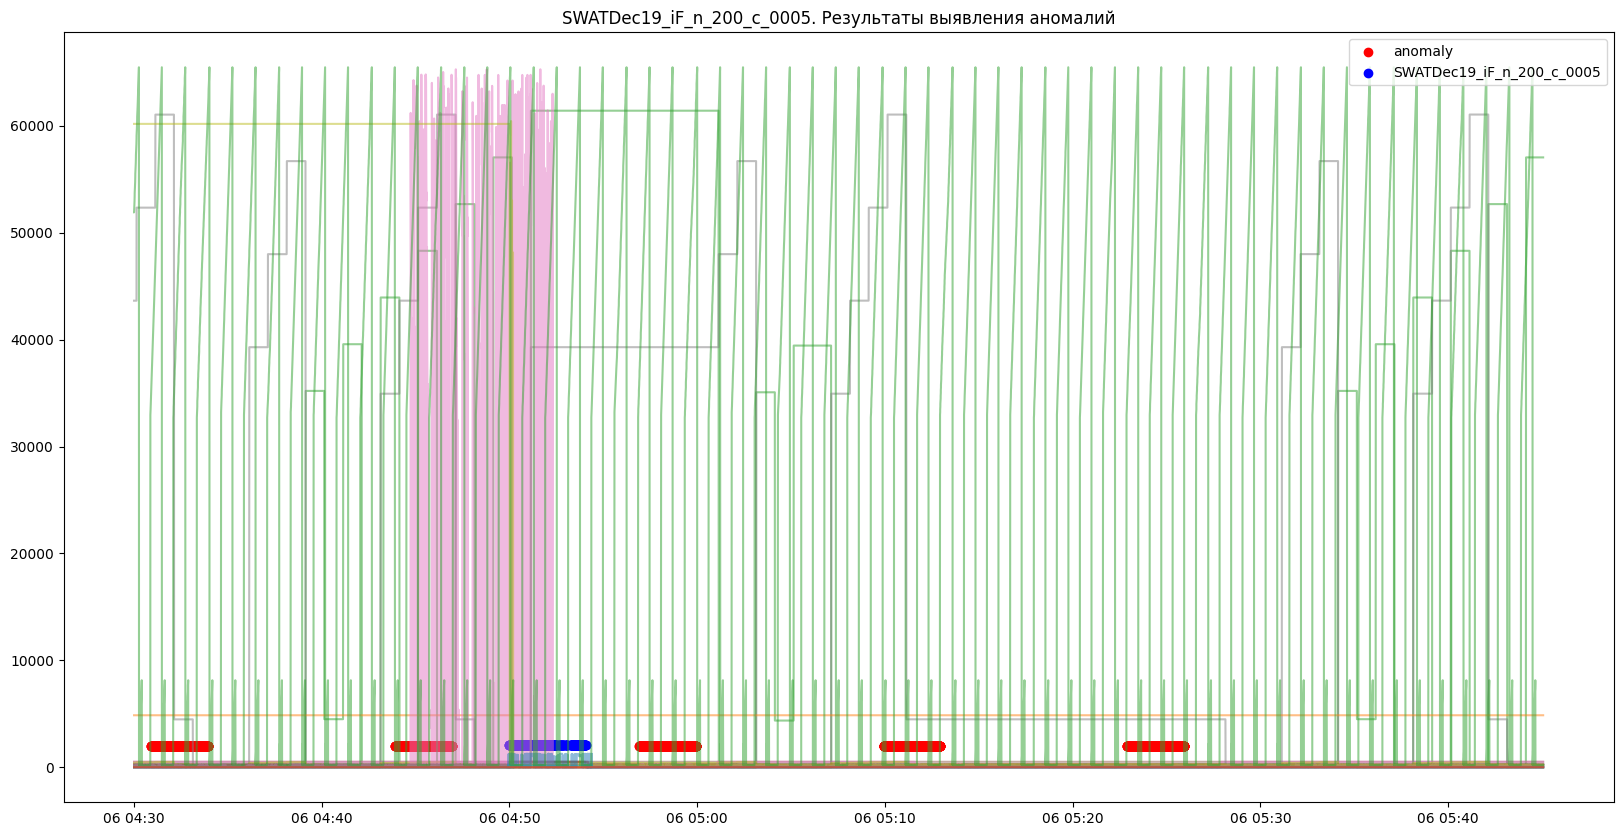

In [383]:
description = f'SWATDec19_iF_n_200_c_0005'

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

model = iForest(n_estimators=200, contamination=0.005)

predictor = Predictor(model, [x_train, x_test, y_test], descr=description, resave_model=True)
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## Autoencoder

Scaling... (Standard)
Количество аномалий: 20.1%

Counter({0: 23968, 1: 6034})
Resampling... (1T)
(146, 23), (76, 23), (76,),
Create sequences with window size 30...
Размеры выборок:
            x_train: (54377, 30, 23)
            x_test: (29973, 30, 23)
            y_test: (29973, 30)


2022-09-03 22:59:19.185731: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-09-03 22:59:20.225857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-03 22:59:20.226271: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.8GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-09-03 22:59:20.226317: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-03 22:59:20.226740: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:

2022-09-03 22:59:20.271074: can't find saved model, fit model...
Epoch 1/10
55/55 [==============================] - 8s 151ms/step - loss: 2.6407
Epoch 2/10
55/55 [==============================] - 8s 150ms/step - loss: 0.3927
Epoch 3/10
55/55 [==============================] - 8s 150ms/step - loss: 0.2020
Epoch 4/10
55/55 [==============================] - 8s 150ms/step - loss: 0.1471
Epoch 5/10
55/55 [==============================] - 8s 150ms/step - loss: 0.1233
Epoch 6/10
55/55 [==============================] - 8s 150ms/step - loss: 0.1110
Epoch 7/10
55/55 [==============================] - 8s 150ms/step - loss: 0.1021
Epoch 8/10
55/55 [==============================] - 8s 150ms/step - loss: 0.0965
Epoch 9/10
55/55 [==============================] - 8s 150ms/step - loss: 0.0922
Epoch 10/10
55/55 [==============================] - 8s 150ms/step - loss: 0.0892
Train prediction score statistics
            min: 0.6062323983253745
            mean: 2.3749894523683435
            max: 

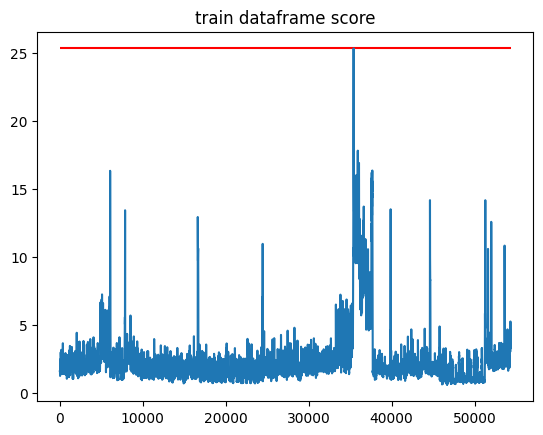

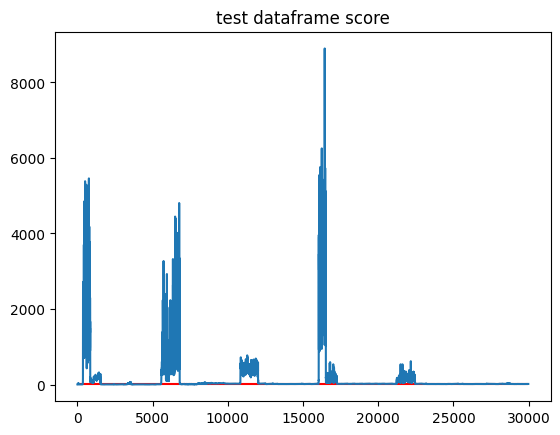

(29973,)
SWATDec19_ae_lstm_window_30_resample_1T
f1_score: 0.86
accuracy_score: 0.94
precision_score: 0.76
recall_score: 1.00


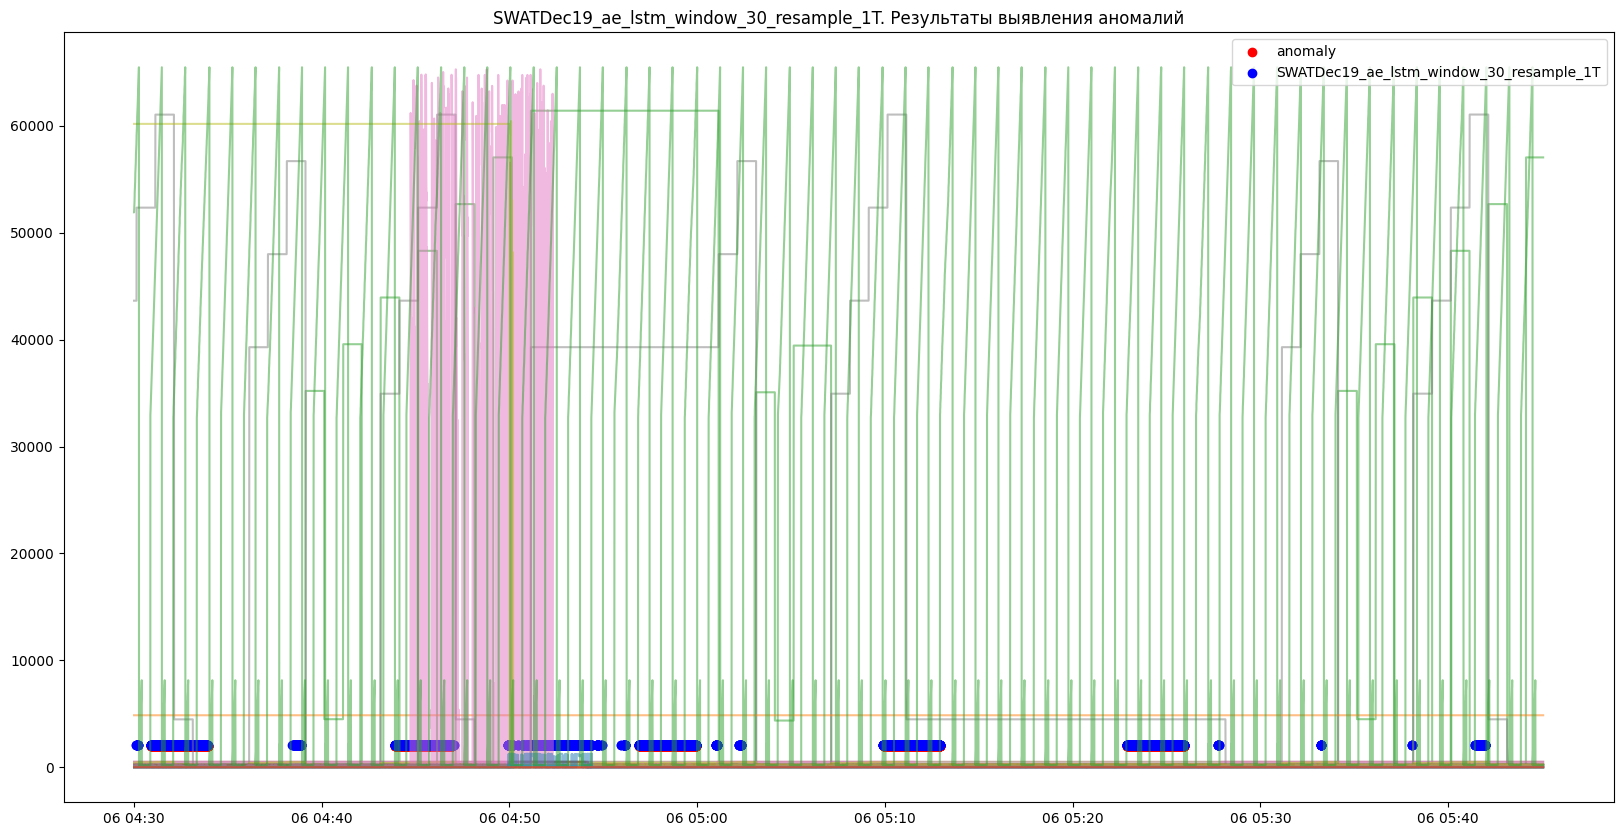

In [384]:
window_size = 30
resample_rate = '1T'

description = f'SWATDec19_ae_lstm_window_{window_size}_resample_{resample_rate}'

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy(), 
                                        window_size=window_size, 
                                        resample_rate=resample_rate)

model = AE_LSTM()

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description, 
                      window_size=window_size,
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=description)

In [ ]:
y_pred = predictor.get_anomalies(threshold=100)
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=description + '_thresh_800')

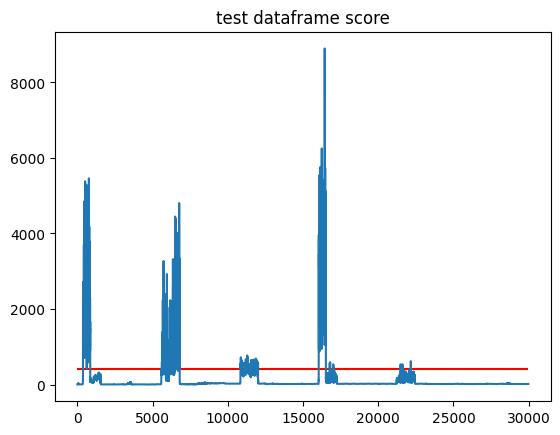

(29973,)
SWATDec19_ae_lstm_window_30_resample_1T
f1_score: 0.60
accuracy_score: 0.88
precision_score: 1.00
recall_score: 0.43


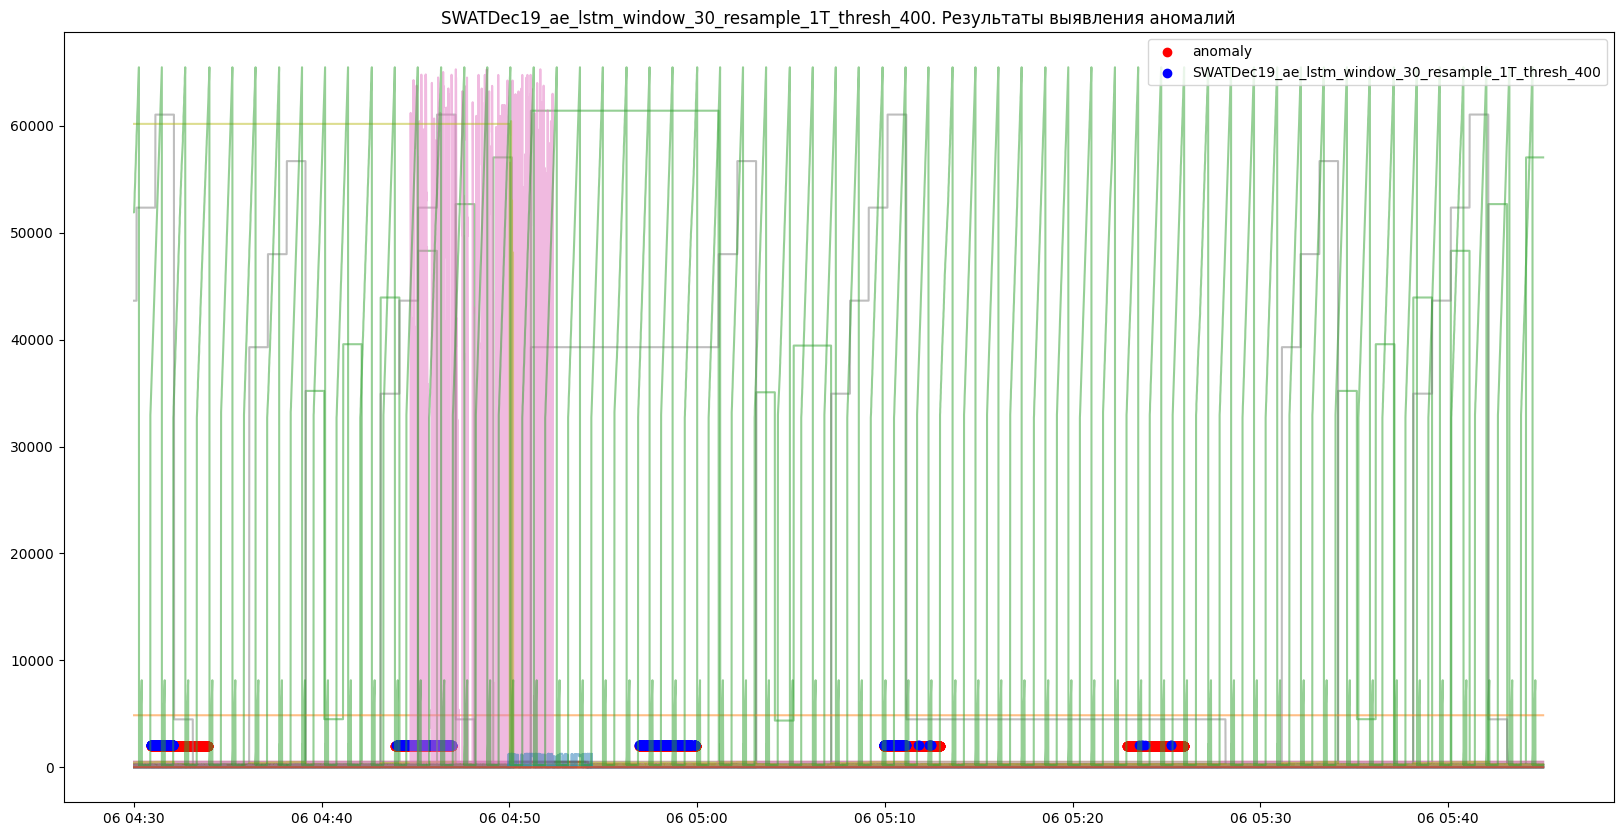

In [386]:
y_pred = predictor.get_anomalies(threshold=400)
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=description + '_thresh_400')

## SOM

In [387]:
x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

Scaling... (Standard)
Количество аномалий: 20.1%

Counter({0: 23968, 1: 6034})
Размеры выборок:
            x_train: (54406, 23)
            x_test: (30002, 23)
            y_test: (30002,)


In [391]:
description = f'SWATDec19_som_default'

model = SOM(x_train)

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description,
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

2022-09-03 23:02:47.182513: find saved model: ./saved_models/SWATDec19_som_default, loading...


IntProgress(value=0, description='Computing', max=30002, style=ProgressStyle(bar_color='#61dc8a'))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IntProgress(value=0, description='Computing', max=54406, style=ProgressStyle(bar_color='#61dc8a'))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IntProgress(value=0, description='Computing', max=30002, style=ProgressStyle(bar_color='#61dc8a'))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

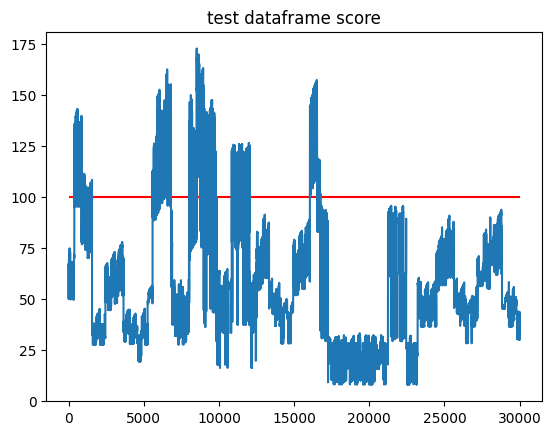

(30002,)
SWATDec19_som_default
f1_score: 0.61
accuracy_score: 0.86
precision_score: 0.72
recall_score: 0.53


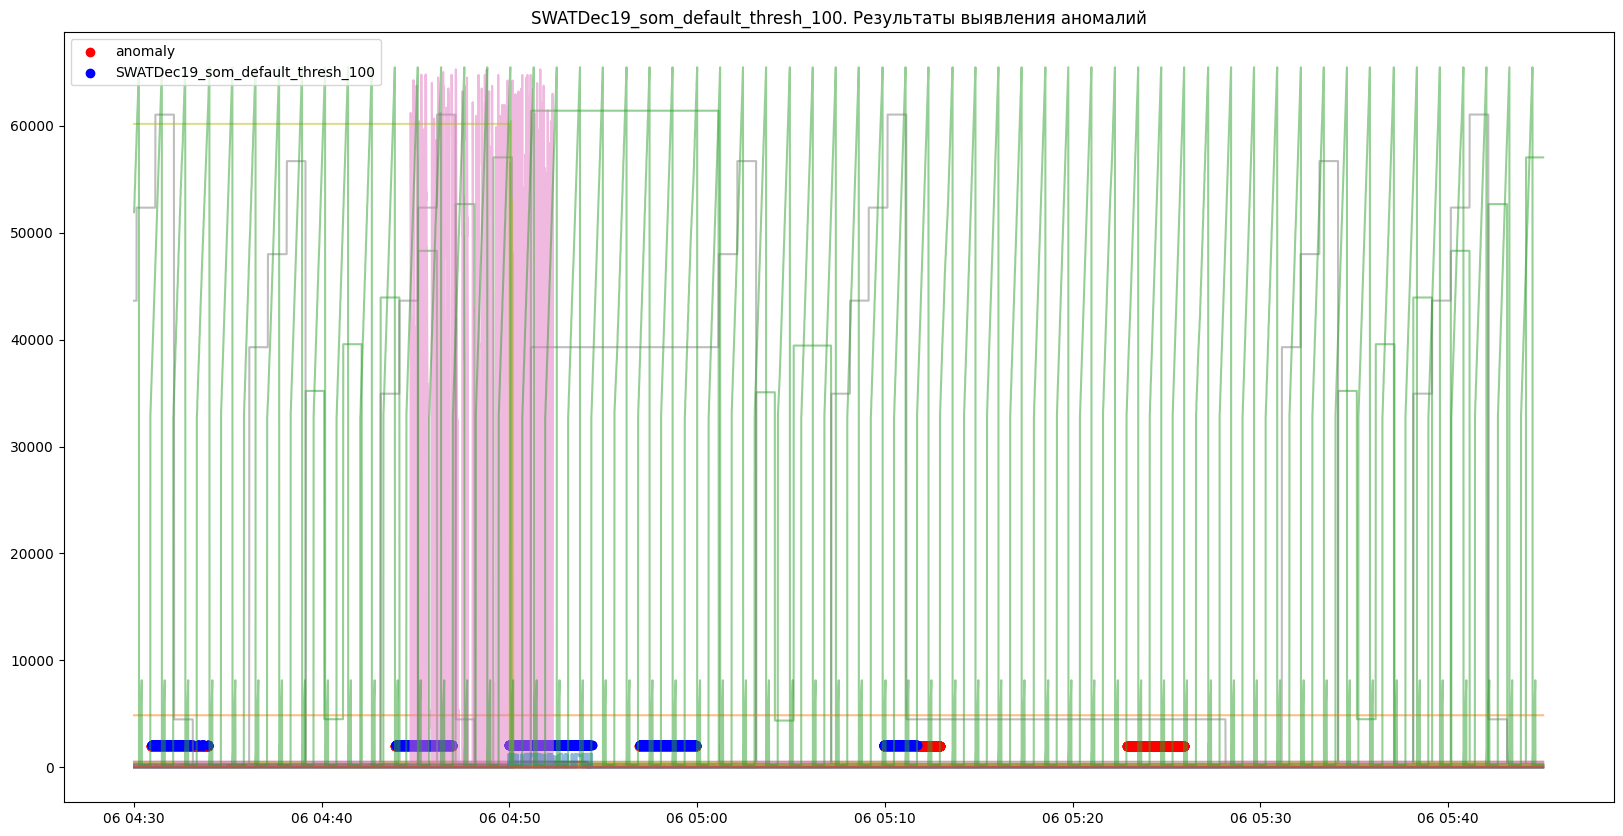

In [394]:
y_pred = predictor.get_anomalies(threshold=100)
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description+'_thresh_100')

# Сводная таблица

In [396]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

df_summary = pd.DataFrame(summary).T
df_summary.style.background_gradient(cmap='Blues')

,f1_score,accuracy_score,precision_score,recall_score
SWATDec19_svm_default,0.627936,0.762416,0.458321,0.996851
SWATDec19_svm_minmax,0.465302,0.539531,0.303540,0.996188
SWATDec19_lof_n5,0.268207,0.799380,0.503423,0.182797
SWATDec19_lof_n5_thr_30,0.335679,0.203953,0.201691,1.000000
SWATDec19_iF_default,0.000000,0.789647,0.000000,0.000000
SWATDec19_iF_n_200_c_0005,0.000000,0.773148,0.000000,0.000000
SWATDec19_ae_lstm_window_30_resample_1T,0.600116,0.884930,0.998842,0.428903
SWATDec19_som_default,0.609831,0.864542,0.724783,0.526351
